In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7"

from unet_2D import *
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from PIL import Image
import PIL
import skimage.transform 
import skimage.io as io
import torch.nn.functional as F


print(os.getcwd())
print(torch.__version__)

/home/ubuntu/Documents/skull_stripping
0.3.0.post4


## Hyperparameter

In [2]:
# 32 per gpu 256
#  8 per gpu 512

batch_size = 64
test_batch_size = 8
img_size = 512
lr = 0.0002
epoch = 1000

in_dim = 3
out_dim = 2
num_filter = 16

crop_rate = 0.58

'''
for i in range(50):
    random_crop = (1-crop_rate)*np.random.random_sample()+crop_rate
    print(random_crop)
'''

'\nfor i in range(50):\n    random_crop = (1-crop_rate)*np.random.random_sample()+crop_rate\n    print(random_crop)\n'

In [3]:
def randomize():
    rand_rotate = np.random.randint(0,4)
    rand_ud = np.random.randint(0,2)
    rand_lr = np.random.randint(0,2)
    rand_gaussian= np.random.randint(1,5)
    rand_crop = (1-crop_rate)*np.random.random_sample()+crop_rate
    rand_crop = np.int(img_size*rand_crop)
    
    a = img_size-rand_crop
    crop_start = np.random.randint(a,size=2)
    
    return rand_rotate,rand_ud,rand_lr,rand_gaussian,rand_crop,crop_start

## Data Augmentation

In [4]:
# Input as PIL image
def random_rotate(img): 
    global rand_rotate
    rand_rotate,rand_ud,rand_lr,rand_gaussian,rand_crop,crop_start = randomize()
    
    left = np.asarray(img)[:,:img_size]
    right = np.asarray(img)[:,img_size:]
                
    left = np.rot90(left,k=rand_rotate)
    right = np.rot90(right,k=rand_rotate)
    concat = np.concatenate([left,right],axis=1)
    return concat

# Input as PIL image
def flip_ud(img):    
    global rand_ud
    rand_rotate,rand_ud,rand_lr,rand_gaussian,rand_crop,crop_start = randomize()
    
    left = np.asarray(img)[:,:img_size]
    right = np.asarray(img)[:,img_size:]
                
    if rand_ud%2==0:    
        left = np.flipud(left)
        right = np.flipud(right)
        #print("flip_ud")
        
    concat = np.concatenate([left,right],axis=1)
    return concat

# Input as PIL image
def flip_lr(img):    
    global rand_lr
    rand_rotate,rand_ud,rand_lr,rand_gaussian,rand_crop,crop_start = randomize()
    
    left = np.asarray(img)[:,:img_size]
    right = np.asarray(img)[:,img_size:]
                
    if rand_lr%2==0:    
        left = np.fliplr(left)
        right = np.fliplr(right)
        #print("flip_lr")
        
    concat = np.concatenate([left,right],axis=1)
    return concat


# Input as PIL image
def random_crop(img):    
    global rand_crop, crop_start
    rand_rotate,rand_ud,rand_lr,rand_gaussian,rand_crop,crop_start = randomize()
    
    left = np.asarray(img)[:,:img_size]
    right = np.asarray(img)[:,img_size:]
        
    # 0.58 to 1
    
    left = left[crop_start[0]:crop_start[0]+rand_crop,
                crop_start[1]:crop_start[1]+rand_crop]
    right = right[crop_start[0]:crop_start[0]+rand_crop,
                  crop_start[1]:crop_start[1]+rand_crop]
    
    left = skimage.transform.resize(left,output_shape=[img_size,img_size],preserve_range=True)
    right = skimage.transform.resize(right,output_shape=[img_size,img_size],preserve_range=True) 
        
    concat = np.concatenate([left,right],axis=1)
    return concat


# Input as tensor
def gaussian_noise(img):
    global rand_gaussian
    rand_rotate,rand_ud,rand_lr,rand_gaussian,rand_crop,crop_start = randomize()    
    
    noise = nn.init.normal(torch.Tensor(3,img_size,img_size),mean=0,std=0.02*(rand_gaussian))
    left = img[:,:,:img_size]+noise
    right = img[:,:,img_size:]
    right[right>0]=1.0
    
    concat = torch.cat([left,right],dim=2)
    return concat    

# Input as tesnor
def minmax_norm(img,infer=False):
    
    if infer:
        left = img[:,:,:img_size]
        left = (left-left.min())/(left.max()-left.min())
        return left
    else:
        left = img[:,:,:img_size]
        right = img[:,:,img_size:]
        left = (left-left.min())/(left.max()-left.min())
        mask = right.gt(0).type_as(torch.FloatTensor())
        concat = torch.cat([left,mask],dim=2)
    return concat

## DataLoader

In [5]:
train_dir = "./IBSR_skull/train/"
train_data = dset.ImageFolder(root=train_dir, transform = transforms.Compose([
                                            transforms.Resize(size=img_size),
                                            transforms.Lambda(lambda x: random_rotate(x)),
                                            transforms.Lambda(lambda x: flip_ud(x)),
                                            transforms.Lambda(lambda x: flip_lr(x)),
                                            transforms.Lambda(lambda x: random_crop(x)),
                                            transforms.ToTensor(),
                                            transforms.Lambda(lambda x: gaussian_noise(x)),
                                            #transforms.Lambda(lambda x: minmax_norm(x)),
                                            ]))
train_batch = data.DataLoader(train_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

test_dir = "./IBSR_skull/test/"
test_data = dset.ImageFolder(root=test_dir, transform = transforms.Compose([
                                            transforms.Resize(size=img_size),
                                            transforms.ToTensor(),
                                            #transforms.Lambda(lambda x: minmax_norm(x)),
                                            ]))
test_batch = data.DataLoader(test_data, batch_size=test_batch_size,
                            shuffle=True, num_workers=2)

## Show Variable as Image

In [6]:
'''
# Input size: batch,2,512,512
def output_visualizer(output_img):
    for i in range(output_img.size()[0]):
        mask = torch.gt(output_img[0,1,:,:],output_img[0,0,:,:])
    
    mask= mask.cpu().data.numpy()
    plt.imshow(mask,cmap="gray")
    
    return
'''

'\n# Input size: batch,2,512,512\ndef output_visualizer(output_img):\n    for i in range(output_img.size()[0]):\n        mask = torch.gt(output_img[0,1,:,:],output_img[0,0,:,:])\n    \n    mask= mask.cpu().data.numpy()\n    plt.imshow(mask,cmap="gray")\n    \n    return\n'

# Visualization

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


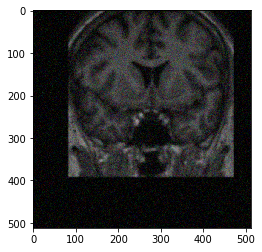

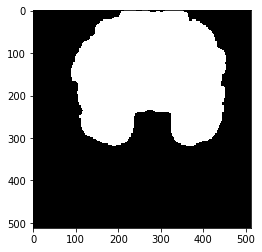

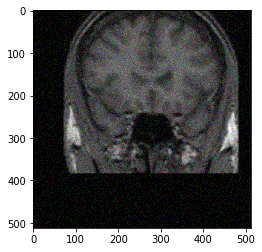

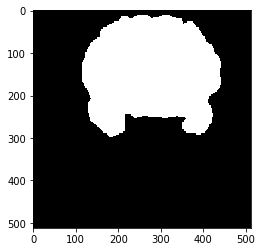

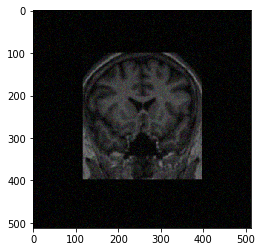

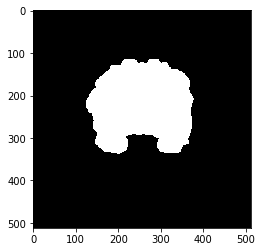

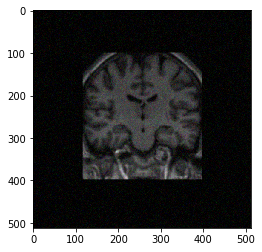

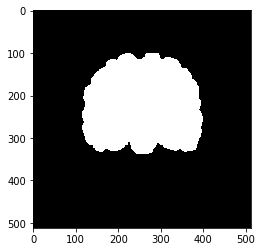

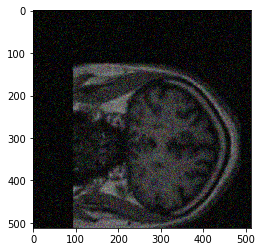

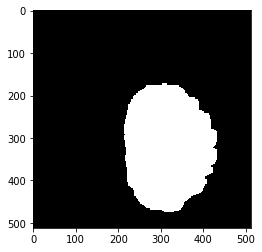

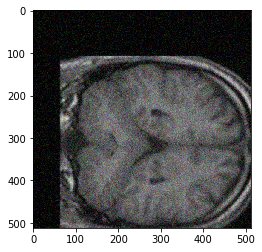

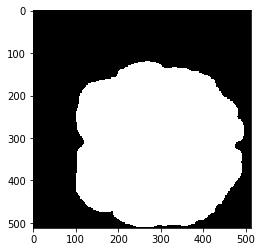

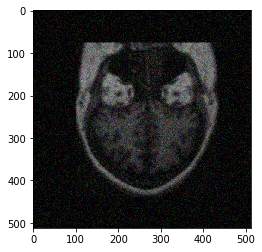

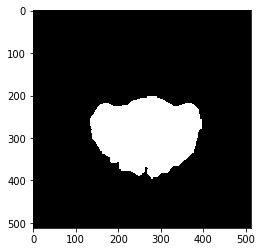

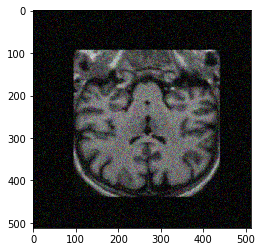

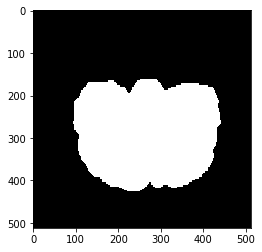

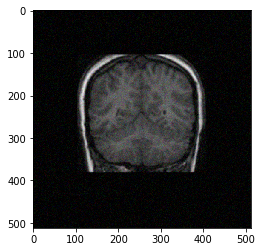

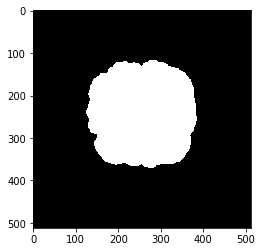

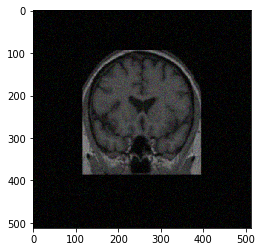

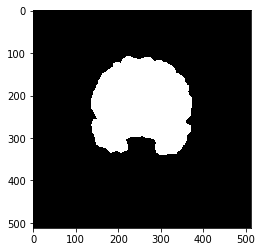

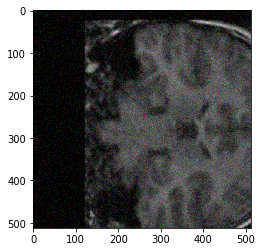

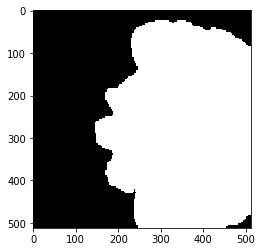

In [7]:
for i,(image,_) in enumerate(train_batch):
    rand_rotate,rand_ud,rand_lr,rand_gaussian,rand_crop,crop_start = randomize()    
    
    image, label = torch.chunk(image,chunks=2, dim=3)
    
    #print(image.size(),label.size())
    
    image_show = np.transpose(image[0].numpy(),[1,2,0])
    label_show = np.transpose(label[0].numpy(),[1,2,0])
    
    #label_show[label_show != 0.0]=1.0
    
    image_show = np.clip(image_show,0.0,1.0)
    label_show = np.clip(label_show,0.0,1.0)
    
    plt.imshow(image_show)
    plt.show()
    plt.imshow(label_show)
    plt.show()
    
    if i == 10:
        break
    
#print(image.max())
#print(label.max())

## Loss Function & Optimizer

In [8]:
def loss_function_crossentropy(output,label):
    batch_size,channel,x,y = output.size()
    log_softmax_2d = torch.log(nn.Softmax2d()(output))
    criterion = nn.NLLLoss2d(size_average=True)
    loss = criterion(log_softmax_2d,label)
    return loss

def loss_function_mse(output,label):
    criterion = nn.L1Loss()
    loss = criterion(output,label)
    return loss

In [9]:
model = nn.DataParallel(UnetGenerator(in_dim=in_dim,
                                      out_dim=out_dim,
                                      num_filter = num_filter)
                       ).cuda()
optimizer = optim.Adam(model.parameters(),lr=lr)

#model


------Initiating U-Net------



In [10]:
def variable_visualizer(input_img,output_img,label):
    image = input_img.cpu().data
    image_show = np.transpose(image[0].numpy(),[1,2,0])
    
    plt.imshow(image_show,cmap="gray")
    plt.show()
    
    #print(output_img.size())
    
    output_img = nn.Softmax2d()(output_img)
    output_img = torch.gt(output_img[0,1,:,:],output_img[0,0,:,:])
    
    mask= output_img.cpu().data.numpy()
    #print(mask.shape)
    
    plt.imshow(mask,cmap="gray")
    plt.show()
    
    try:
        label_show = label[0].numpy()
        plt.imshow(label_show,cmap="gray")
        plt.show()
    except:
        print("label not shown")
        return
    
    return

## Train


 epoch: 0 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.5807665]

 - testing.. 

0 [ 0.62538075]


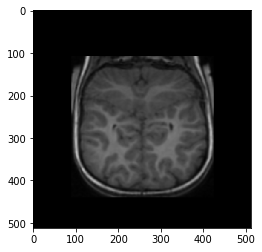

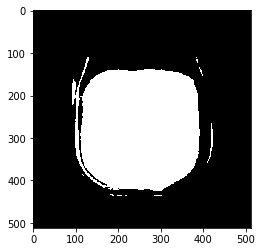

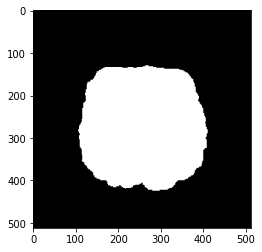


 epoch: 1 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.52336484]

 - testing.. 


 epoch: 2 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.48891473]

 - testing.. 


 epoch: 3 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.45447466]

 - testing.. 


 epoch: 4 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.42614934]

 - testing.. 


 epoch: 5 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.40989056]

 - testing.. 


 epoch: 6 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.39613885]

 - testing.. 


 epoch: 7 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.37569159]

 - testing.. 


 epoch: 8 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.37891856]

 - testing.. 


 epoch: 9 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3679392]

 - testing.. 


 epoch: 10 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.36659747]

 - testing.. 

10 [ 0.48139644]


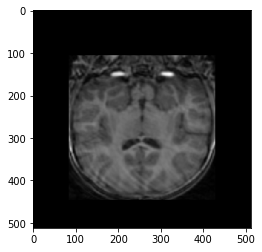

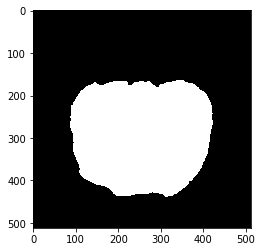

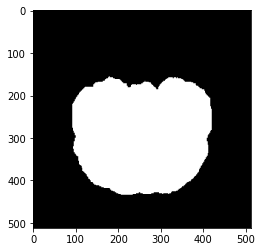


 epoch: 11 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.35508573]

 - testing.. 


 epoch: 12 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.35426942]

 - testing.. 


 epoch: 13 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.34604278]

 - testing.. 


 epoch: 14 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.34395534]

 - testing.. 


 epoch: 15 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.34189388]

 - testing.. 


 epoch: 16 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.34208745]

 - testing.. 


 epoch: 17 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.33601385]

 - testing.. 


 epoch: 18 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3376002]

 - testing.. 


 epoch: 19 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.33655623]

 - testing.. 


 epoch: 20 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.33692399]

 - testing.. 

20 [ 0.34308335]


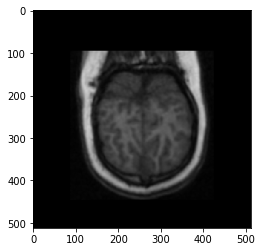

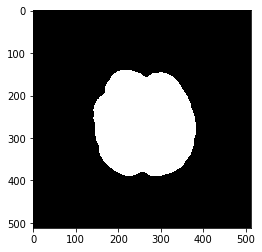

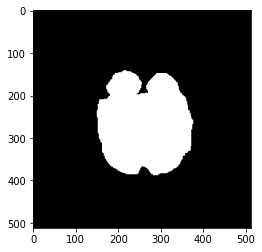


 epoch: 21 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.33661205]

 - testing.. 


 epoch: 22 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.33575183]

 - testing.. 


 epoch: 23 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.33309782]

 - testing.. 


 epoch: 24 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.33191884]

 - testing.. 


 epoch: 25 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.33103913]

 - testing.. 


 epoch: 26 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.33010411]

 - testing.. 


 epoch: 27 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32787469]

 - testing.. 


 epoch: 28 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32859394]

 - testing.. 


 epoch: 29 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32727575]

 - testing.. 


 epoch: 30 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32845414]

 - testing.. 

30 [ 0.41513824]


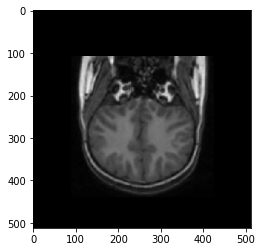

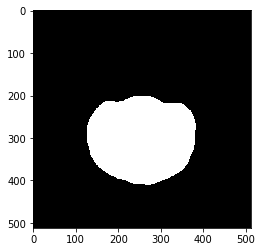

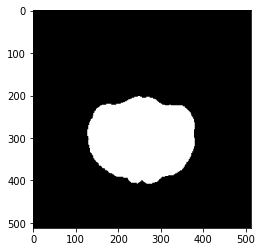


 epoch: 31 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32740343]

 - testing.. 


 epoch: 32 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32907036]

 - testing.. 


 epoch: 33 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32664186]

 - testing.. 


 epoch: 34 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32721576]

 - testing.. 


 epoch: 35 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32696459]

 - testing.. 


 epoch: 36 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3277871]

 - testing.. 


 epoch: 37 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32768673]

 - testing.. 


 epoch: 38 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32944736]

 - testing.. 


 epoch: 39 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32623896]

 - testing.. 


 epoch: 40 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32642189]

 - testing.. 

40 [ 0.49384061]


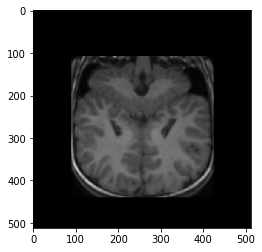

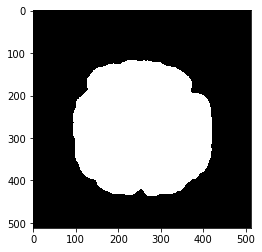

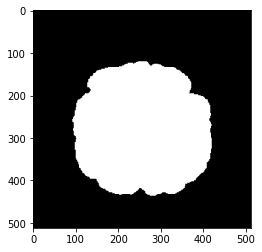


 epoch: 41 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32659325]

 - testing.. 


 epoch: 42 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32519621]

 - testing.. 


 epoch: 43 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32483378]

 - testing.. 


 epoch: 44 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32721817]

 - testing.. 


 epoch: 45 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32588437]

 - testing.. 


 epoch: 46 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32568043]

 - testing.. 


 epoch: 47 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.324819]

 - testing.. 


 epoch: 48 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32509896]

 - testing.. 


 epoch: 49 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32390925]

 - testing.. 


 epoch: 50 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3263849]

 - testing.. 

50 [ 0.36476362]


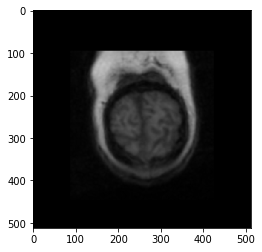

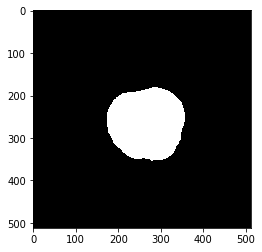

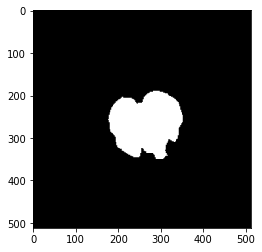


 epoch: 51 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32508403]

 - testing.. 


 epoch: 52 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32909068]

 - testing.. 


 epoch: 53 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32462364]

 - testing.. 


 epoch: 54 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32611933]

 - testing.. 


 epoch: 55 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32342455]

 - testing.. 


 epoch: 56 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32489091]

 - testing.. 


 epoch: 57 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32627332]

 - testing.. 


 epoch: 58 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32417369]

 - testing.. 


 epoch: 59 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32300591]

 - testing.. 


 epoch: 60 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32554859]

 - testing.. 

60 [ 0.39035252]


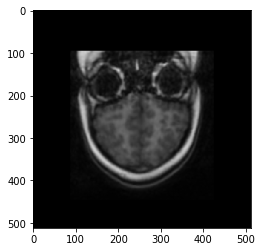

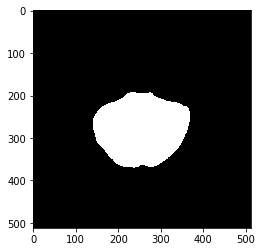

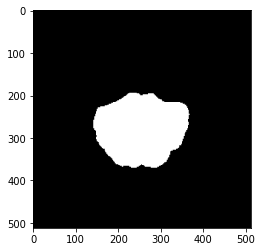


 epoch: 61 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32543489]

 - testing.. 


 epoch: 62 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32270885]

 - testing.. 


 epoch: 63 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32541189]

 - testing.. 


 epoch: 64 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3230086]

 - testing.. 


 epoch: 65 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32532611]

 - testing.. 


 epoch: 66 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32318497]

 - testing.. 


 epoch: 67 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32675695]

 - testing.. 


 epoch: 68 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32453391]

 - testing.. 


 epoch: 69 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32346001]

 - testing.. 


 epoch: 70 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32450879]

 - testing.. 

70 [ 0.38106066]


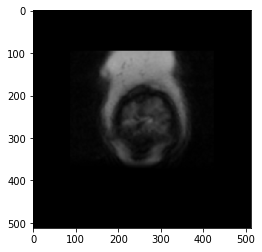

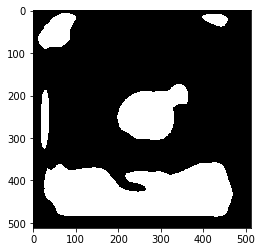

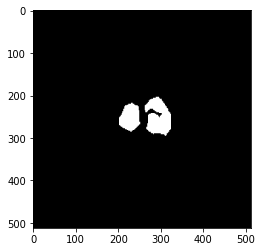


 epoch: 71 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32384267]

 - testing.. 


 epoch: 72 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32450348]

 - testing.. 


 epoch: 73 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32449779]

 - testing.. 


 epoch: 74 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3228977]

 - testing.. 


 epoch: 75 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32356641]

 - testing.. 


 epoch: 76 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32296631]

 - testing.. 


 epoch: 77 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32385862]

 - testing.. 


 epoch: 78 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32412392]

 - testing.. 


 epoch: 79 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3222484]

 - testing.. 


 epoch: 80 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32255995]

 - testing.. 

80 [ 0.3350684]


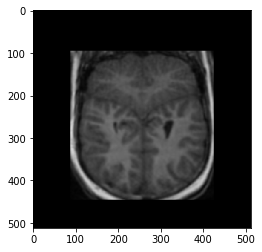

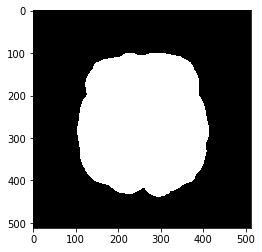

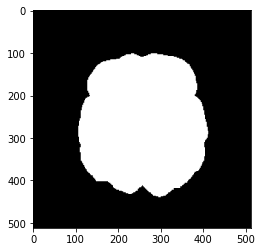


 epoch: 81 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32578868]

 - testing.. 


 epoch: 82 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32463822]

 - testing.. 


 epoch: 83 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32318166]

 - testing.. 


 epoch: 84 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32273141]

 - testing.. 


 epoch: 85 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32372111]

 - testing.. 


 epoch: 86 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32294163]

 - testing.. 


 epoch: 87 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32372752]

 - testing.. 


 epoch: 88 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32332045]

 - testing.. 


 epoch: 89 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32236952]

 - testing.. 


 epoch: 90 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32295924]

 - testing.. 

90 [ 0.3310312]


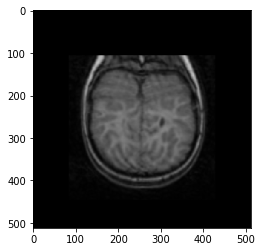

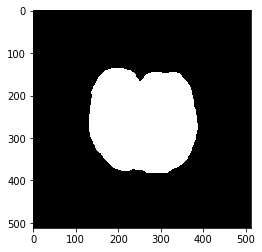

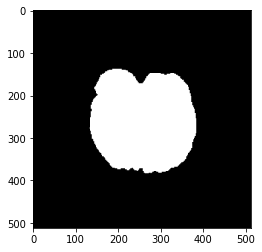


 epoch: 91 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32192037]

 - testing.. 


 epoch: 92 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32267612]

 - testing.. 


 epoch: 93 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32330593]

 - testing.. 


 epoch: 94 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32425985]

 - testing.. 


 epoch: 95 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3223865]

 - testing.. 


 epoch: 96 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32272589]

 - testing.. 


 epoch: 97 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32397342]

 - testing.. 


 epoch: 98 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32365561]

 - testing.. 


 epoch: 99 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32236588]

 - testing.. 


 epoch: 100 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32252932]

 - testing.. 

100 [ 0.38918102]


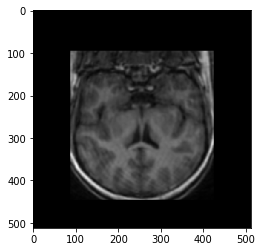

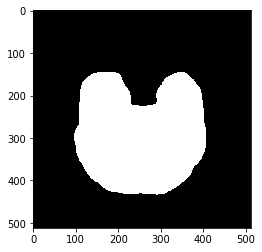

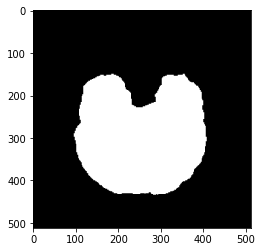


 epoch: 101 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32393661]

 - testing.. 


 epoch: 102 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32215819]

 - testing.. 


 epoch: 103 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32463336]

 - testing.. 


 epoch: 104 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32238173]

 - testing.. 


 epoch: 105 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32340708]

 - testing.. 


 epoch: 106 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32257277]

 - testing.. 


 epoch: 107 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32291037]

 - testing.. 


 epoch: 108 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32397762]

 - testing.. 


 epoch: 109 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32248381]

 - testing.. 


 epoch: 110 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32270327]

 - testing.. 

110 [ 0.57507062]


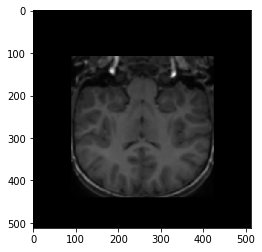

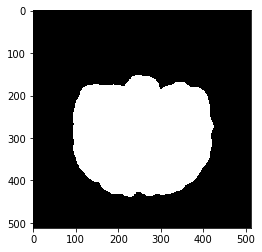

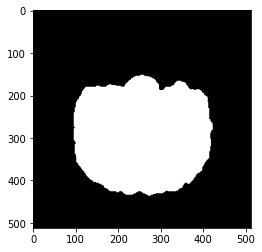


 epoch: 111 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32288814]

 - testing.. 


 epoch: 112 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32235163]

 - testing.. 


 epoch: 113 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32449526]

 - testing.. 


 epoch: 114 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32324871]

 - testing.. 


 epoch: 115 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32295659]

 - testing.. 


 epoch: 116 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32425773]

 - testing.. 


 epoch: 117 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32216746]

 - testing.. 


 epoch: 118 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32387301]

 - testing.. 


 epoch: 119 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3243995]

 - testing.. 


 epoch: 120 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32211405]

 - testing.. 

120 [ 0.32782477]


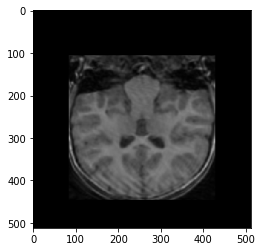

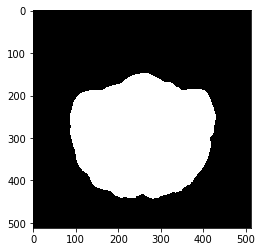

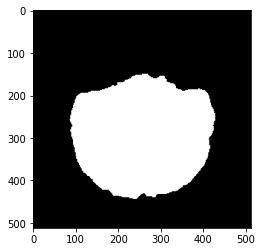


 epoch: 121 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32391945]

 - testing.. 


 epoch: 122 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32364348]

 - testing.. 


 epoch: 123 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3223857]

 - testing.. 


 epoch: 124 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32180366]

 - testing.. 


 epoch: 125 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32278794]

 - testing.. 


 epoch: 126 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32183462]

 - testing.. 


 epoch: 127 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32242873]

 - testing.. 


 epoch: 128 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32366365]

 - testing.. 


 epoch: 129 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32276013]

 - testing.. 


 epoch: 130 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32218724]

 - testing.. 

130 [ 0.32859677]


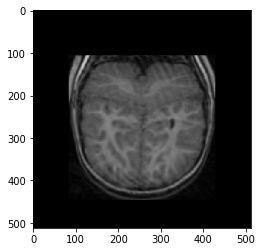

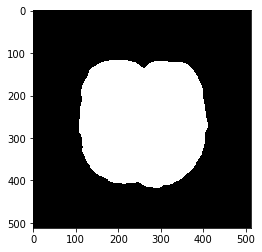

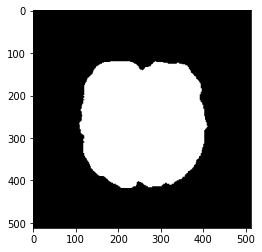


 epoch: 131 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32171309]

 - testing.. 


 epoch: 132 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32234848]

 - testing.. 


 epoch: 133 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32265192]

 - testing.. 


 epoch: 134 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32354513]

 - testing.. 


 epoch: 135 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32315361]

 - testing.. 


 epoch: 136 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32208398]

 - testing.. 


 epoch: 137 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32311812]

 - testing.. 


 epoch: 138 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32558903]

 - testing.. 


 epoch: 139 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32250819]

 - testing.. 


 epoch: 140 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32270223]

 - testing.. 

140 [ 0.39848286]


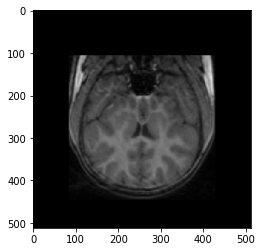

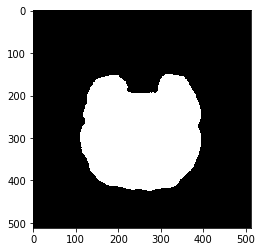

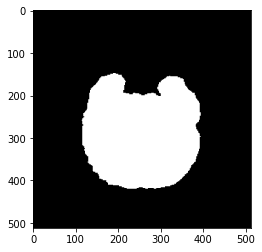


 epoch: 141 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32468322]

 - testing.. 


 epoch: 142 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32235008]

 - testing.. 


 epoch: 143 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32301721]

 - testing.. 


 epoch: 144 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32318938]

 - testing.. 


 epoch: 145 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32444781]

 - testing.. 


 epoch: 146 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32137221]

 - testing.. 


 epoch: 147 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3229503]

 - testing.. 


 epoch: 148 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32353869]

 - testing.. 


 epoch: 149 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32272515]

 - testing.. 


 epoch: 150 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32388756]

 - testing.. 

150 [ 0.36072895]


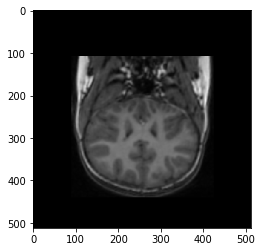

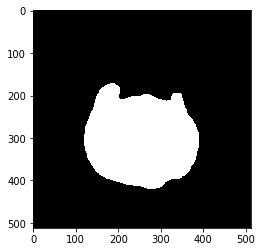

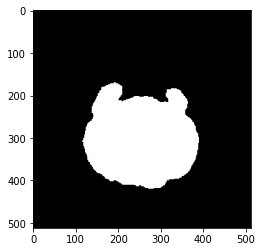


 epoch: 151 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32451406]

 - testing.. 


 epoch: 152 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3228527]

 - testing.. 


 epoch: 153 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32286978]

 - testing.. 


 epoch: 154 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32247558]

 - testing.. 


 epoch: 155 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32249334]

 - testing.. 


 epoch: 156 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32217419]

 - testing.. 


 epoch: 157 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32262769]

 - testing.. 


 epoch: 158 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32346871]

 - testing.. 


 epoch: 159 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32264638]

 - testing.. 


 epoch: 160 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32311684]

 - testing.. 

160 [ 0.40006346]


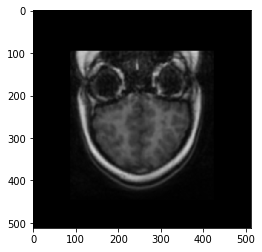

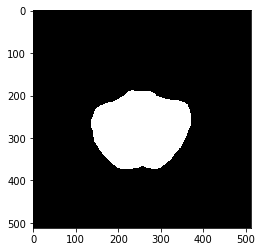

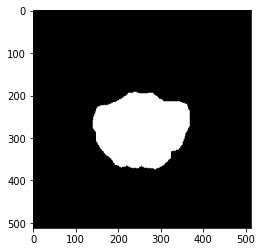


 epoch: 161 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32261443]

 - testing.. 


 epoch: 162 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32166135]

 - testing.. 


 epoch: 163 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32291195]

 - testing.. 


 epoch: 164 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32182902]

 - testing.. 


 epoch: 165 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32201156]

 - testing.. 


 epoch: 166 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32198262]

 - testing.. 


 epoch: 167 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32191491]

 - testing.. 


 epoch: 168 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32177109]

 - testing.. 


 epoch: 169 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32429436]

 - testing.. 


 epoch: 170 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32251051]

 - testing.. 

170 [ 0.38494328]


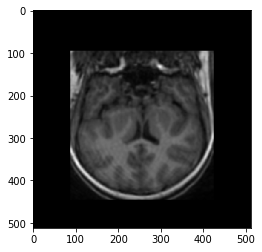

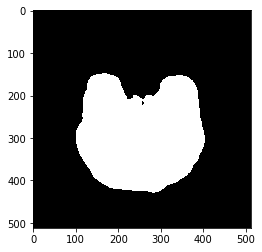

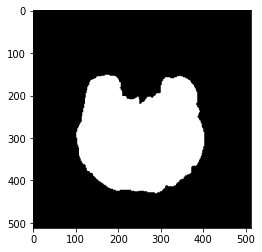


 epoch: 171 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32201663]

 - testing.. 


 epoch: 172 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32110047]

 - testing.. 


 epoch: 173 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32213187]

 - testing.. 


 epoch: 174 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32265291]

 - testing.. 


 epoch: 175 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32142386]

 - testing.. 


 epoch: 176 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32272139]

 - testing.. 


 epoch: 177 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.33460537]

 - testing.. 


 epoch: 178 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32879576]

 - testing.. 


 epoch: 179 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3250607]

 - testing.. 


 epoch: 180 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3243337]

 - testing.. 

180 [ 0.51654214]


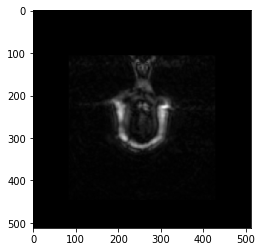

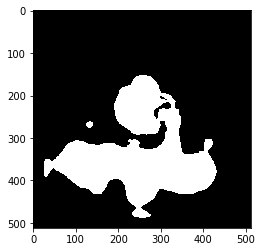

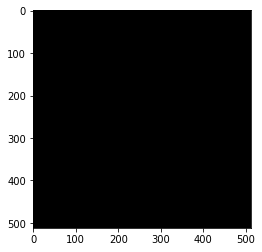


 epoch: 181 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32343549]

 - testing.. 


 epoch: 182 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32306802]

 - testing.. 


 epoch: 183 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32309726]

 - testing.. 


 epoch: 184 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32321757]

 - testing.. 


 epoch: 185 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32258067]

 - testing.. 


 epoch: 186 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32289362]

 - testing.. 


 epoch: 187 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3231765]

 - testing.. 


 epoch: 188 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32234403]

 - testing.. 


 epoch: 189 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32408273]

 - testing.. 


 epoch: 190 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32247835]

 - testing.. 

190 [ 0.32856983]


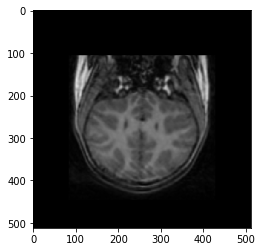

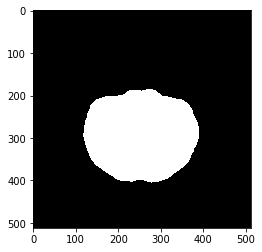

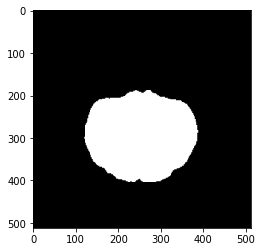


 epoch: 191 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32258931]

 - testing.. 


 epoch: 192 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32249585]

 - testing.. 


 epoch: 193 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32284454]

 - testing.. 


 epoch: 194 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32327276]

 - testing.. 


 epoch: 195 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32225233]

 - testing.. 


 epoch: 196 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32243925]

 - testing.. 


 epoch: 197 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3214491]

 - testing.. 


 epoch: 198 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32185978]

 - testing.. 


 epoch: 199 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32180738]

 - testing.. 


 epoch: 200 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32265487]

 - testing.. 

200 [ 0.45208445]


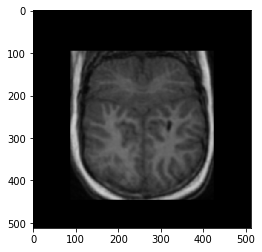

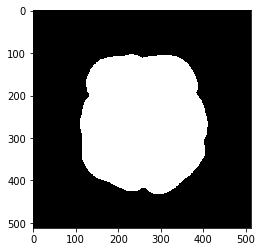

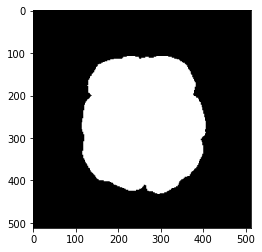


 epoch: 201 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32254586]

 - testing.. 


 epoch: 202 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32262951]

 - testing.. 


 epoch: 203 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32227096]

 - testing.. 


 epoch: 204 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32161015]

 - testing.. 


 epoch: 205 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32211849]

 - testing.. 


 epoch: 206 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32146782]

 - testing.. 


 epoch: 207 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32212144]

 - testing.. 


 epoch: 208 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32207286]

 - testing.. 


 epoch: 209 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32110885]

 - testing.. 


 epoch: 210 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32190931]

 - testing.. 

210 [ 0.32933831]


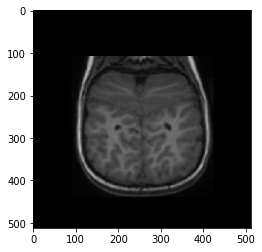

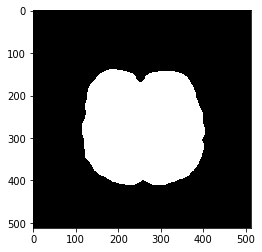

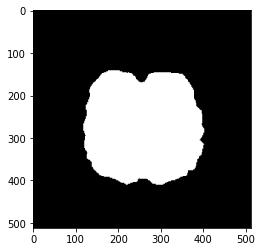


 epoch: 211 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32518187]

 - testing.. 


 epoch: 212 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32388601]

 - testing.. 


 epoch: 213 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32167238]

 - testing.. 


 epoch: 214 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32354161]

 - testing.. 


 epoch: 215 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32215804]

 - testing.. 


 epoch: 216 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32199684]

 - testing.. 


 epoch: 217 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32152218]

 - testing.. 


 epoch: 218 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32087997]

 - testing.. 


 epoch: 219 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32087317]

 - testing.. 


 epoch: 220 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32150489]

 - testing.. 

220 [ 0.39608946]


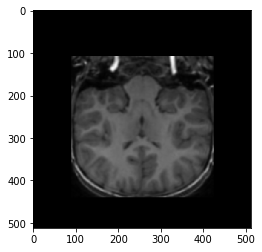

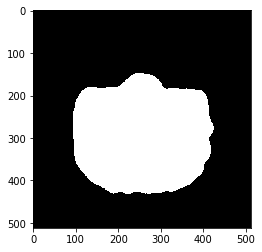

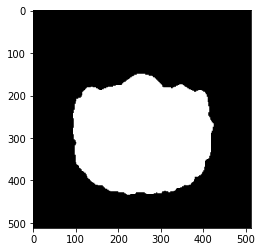


 epoch: 221 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32145602]

 - testing.. 


 epoch: 222 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32139677]

 - testing.. 


 epoch: 223 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32236376]

 - testing.. 


 epoch: 224 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32186949]

 - testing.. 


 epoch: 225 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32113814]

 - testing.. 


 epoch: 226 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3214561]

 - testing.. 


 epoch: 227 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32085076]

 - testing.. 


 epoch: 228 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32302526]

 - testing.. 


 epoch: 229 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32161689]

 - testing.. 


 epoch: 230 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32080302]

 - testing.. 

230 [ 0.38885224]


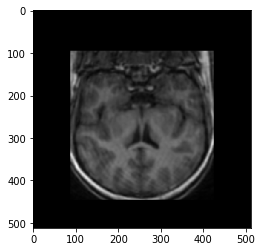

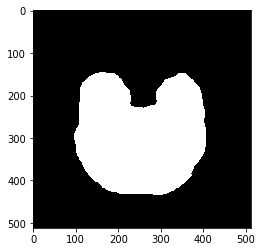

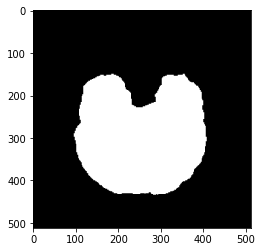


 epoch: 231 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3220683]

 - testing.. 


 epoch: 232 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32147482]

 - testing.. 


 epoch: 233 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32200617]

 - testing.. 


 epoch: 234 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32319748]

 - testing.. 


 epoch: 235 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32160294]

 - testing.. 


 epoch: 236 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3216081]

 - testing.. 


 epoch: 237 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32235563]

 - testing.. 


 epoch: 238 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32175955]

 - testing.. 


 epoch: 239 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3238869]

 - testing.. 


 epoch: 240 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3211059]

 - testing.. 

240 [ 0.39087185]


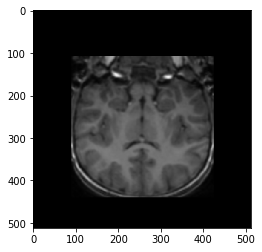

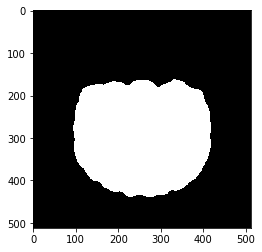

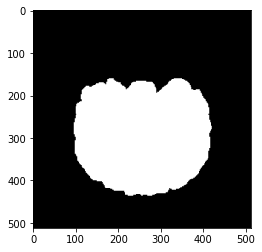


 epoch: 241 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32224014]

 - testing.. 


 epoch: 242 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32135174]

 - testing.. 


 epoch: 243 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32198334]

 - testing.. 


 epoch: 244 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32293838]

 - testing.. 


 epoch: 245 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3208783]

 - testing.. 


 epoch: 246 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32237205]

 - testing.. 


 epoch: 247 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32221895]

 - testing.. 


 epoch: 248 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32195523]

 - testing.. 


 epoch: 249 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32145849]

 - testing.. 


 epoch: 250 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3225373]

 - testing.. 

250 [ 0.35910895]


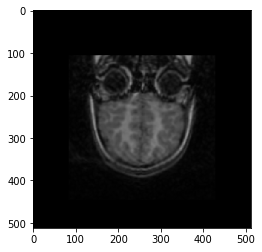

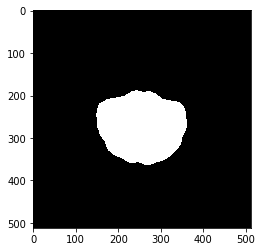

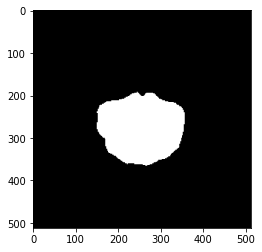


 epoch: 251 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32187411]

 - testing.. 


 epoch: 252 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32217994]

 - testing.. 


 epoch: 253 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.320656]

 - testing.. 


 epoch: 254 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32183135]

 - testing.. 


 epoch: 255 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32139766]

 - testing.. 


 epoch: 256 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32169831]

 - testing.. 


 epoch: 257 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3217271]

 - testing.. 


 epoch: 258 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32149178]

 - testing.. 


 epoch: 259 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32199413]

 - testing.. 


 epoch: 260 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32164729]

 - testing.. 

260 [ 0.45831904]


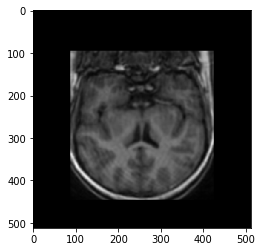

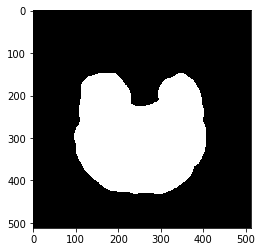

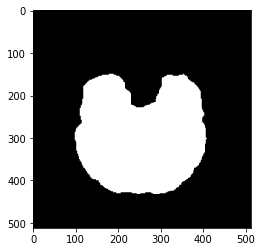


 epoch: 261 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32170478]

 - testing.. 


 epoch: 262 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32110801]

 - testing.. 


 epoch: 263 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32299367]

 - testing.. 


 epoch: 264 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32187018]

 - testing.. 


 epoch: 265 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32224122]

 - testing.. 


 epoch: 266 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32209939]

 - testing.. 


 epoch: 267 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32179922]

 - testing.. 


 epoch: 268 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32340828]

 - testing.. 


 epoch: 269 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32208073]

 - testing.. 


 epoch: 270 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32191879]

 - testing.. 

270 [ 0.32340848]


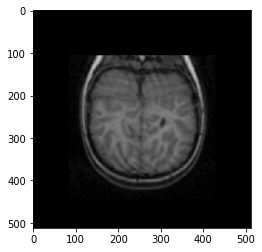

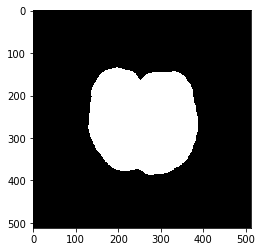

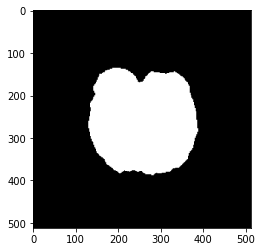


 epoch: 271 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32176098]

 - testing.. 


 epoch: 272 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32222486]

 - testing.. 


 epoch: 273 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32119158]

 - testing.. 


 epoch: 274 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32203627]

 - testing.. 


 epoch: 275 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32093769]

 - testing.. 


 epoch: 276 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32236341]

 - testing.. 


 epoch: 277 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32198527]

 - testing.. 


 epoch: 278 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32112992]

 - testing.. 


 epoch: 279 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32103935]

 - testing.. 


 epoch: 280 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32118478]

 - testing.. 

280 [ 0.39126873]


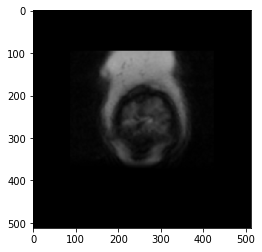

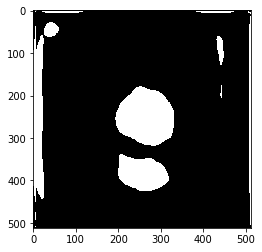

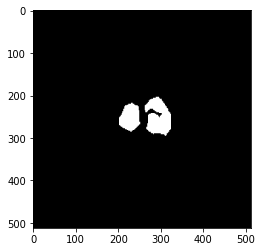


 epoch: 281 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32155544]

 - testing.. 


 epoch: 282 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32146367]

 - testing.. 


 epoch: 283 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32245567]

 - testing.. 


 epoch: 284 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32122806]

 - testing.. 


 epoch: 285 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32119572]

 - testing.. 


 epoch: 286 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32140109]

 - testing.. 


 epoch: 287 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32274437]

 - testing.. 


 epoch: 288 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32167253]

 - testing.. 


 epoch: 289 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32242328]

 - testing.. 


 epoch: 290 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32241365]

 - testing.. 

290 [ 0.38893056]


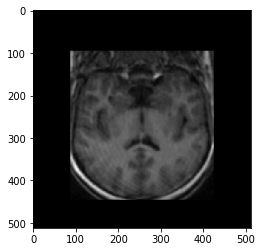

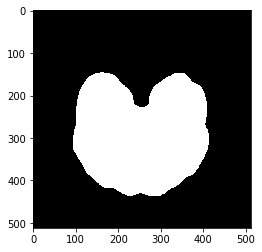

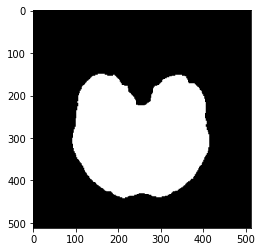


 epoch: 291 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3218962]

 - testing.. 


 epoch: 292 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32242727]

 - testing.. 


 epoch: 293 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3211107]

 - testing.. 


 epoch: 294 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32121772]

 - testing.. 


 epoch: 295 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32152358]

 - testing.. 


 epoch: 296 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32319993]

 - testing.. 


 epoch: 297 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32073921]

 - testing.. 


 epoch: 298 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32124665]

 - testing.. 


 epoch: 299 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32169005]

 - testing.. 


 epoch: 300 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32256827]

 - testing.. 

300 [ 0.33052105]


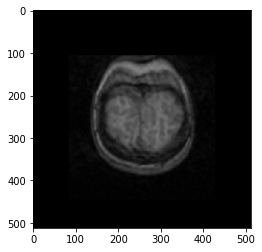

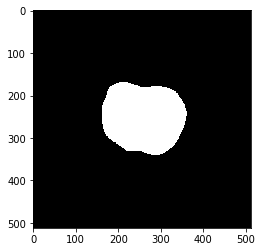

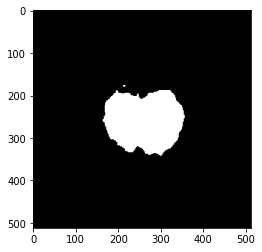


 epoch: 301 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32124341]

 - testing.. 


 epoch: 302 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32079813]

 - testing.. 


 epoch: 303 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32160312]

 - testing.. 


 epoch: 304 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32128203]

 - testing.. 


 epoch: 305 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32230765]

 - testing.. 


 epoch: 306 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32147464]

 - testing.. 


 epoch: 307 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32378569]

 - testing.. 


 epoch: 308 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32084092]

 - testing.. 


 epoch: 309 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32258028]

 - testing.. 


 epoch: 310 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32172239]

 - testing.. 

310 [ 0.32509571]


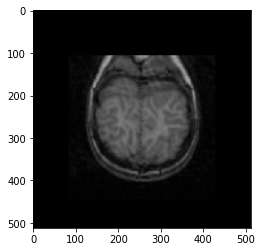

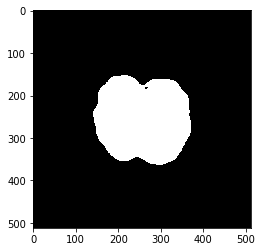

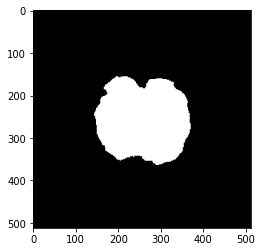


 epoch: 311 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3222481]

 - testing.. 


 epoch: 312 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32397586]

 - testing.. 


 epoch: 313 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32163197]

 - testing.. 


 epoch: 314 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32174176]

 - testing.. 


 epoch: 315 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32108444]

 - testing.. 


 epoch: 316 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32234132]

 - testing.. 


 epoch: 317 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32189116]

 - testing.. 


 epoch: 318 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32220408]

 - testing.. 


 epoch: 319 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32258525]

 - testing.. 


 epoch: 320 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32099885]

 - testing.. 

320 [ 0.32867903]


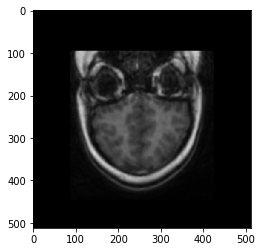

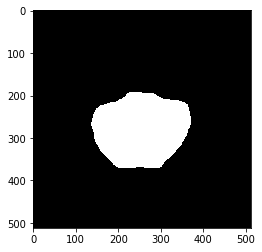

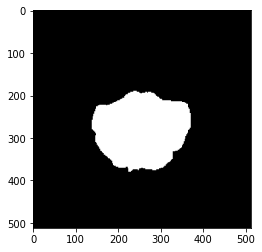


 epoch: 321 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32058468]

 - testing.. 


 epoch: 322 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32194114]

 - testing.. 


 epoch: 323 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32141843]

 - testing.. 


 epoch: 324 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32026297]

 - testing.. 


 epoch: 325 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32066661]

 - testing.. 


 epoch: 326 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32085028]

 - testing.. 


 epoch: 327 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32227185]

 - testing.. 


 epoch: 328 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32070601]

 - testing.. 


 epoch: 329 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32121789]

 - testing.. 


 epoch: 330 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32148913]

 - testing.. 

330 [ 0.32478964]


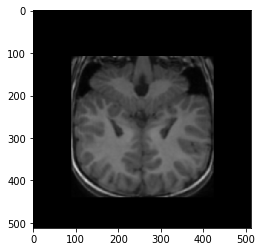

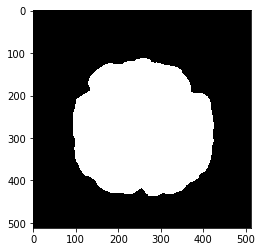

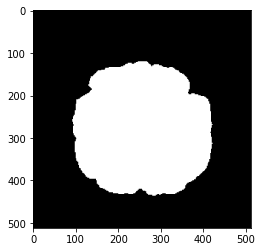


 epoch: 331 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32103845]

 - testing.. 


 epoch: 332 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32196301]

 - testing.. 


 epoch: 333 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32152635]

 - testing.. 


 epoch: 334 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32134664]

 - testing.. 


 epoch: 335 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32392117]

 - testing.. 


 epoch: 336 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32207721]

 - testing.. 


 epoch: 337 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32180357]

 - testing.. 


 epoch: 338 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3207415]

 - testing.. 


 epoch: 339 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32152995]

 - testing.. 


 epoch: 340 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3221769]

 - testing.. 

340 [ 0.39827764]


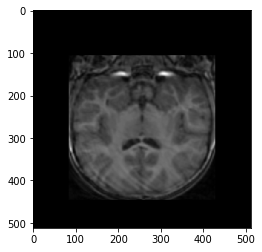

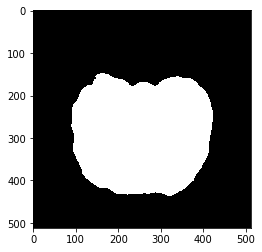

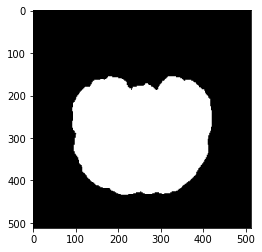


 epoch: 341 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3221494]

 - testing.. 


 epoch: 342 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32076576]

 - testing.. 


 epoch: 343 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32202607]

 - testing.. 


 epoch: 344 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32232845]

 - testing.. 


 epoch: 345 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32157043]

 - testing.. 


 epoch: 346 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3216475]

 - testing.. 


 epoch: 347 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32207128]

 - testing.. 


 epoch: 348 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32180625]

 - testing.. 


 epoch: 349 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32135275]

 - testing.. 


 epoch: 350 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32102996]

 - testing.. 

350 [ 0.32618985]


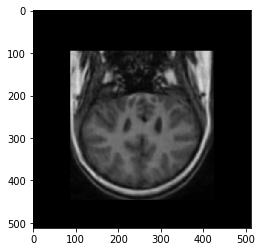

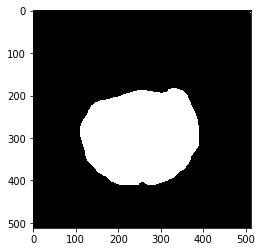

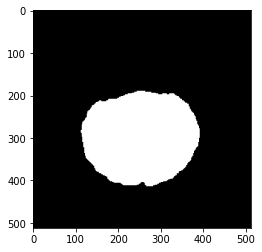


 epoch: 351 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32168809]

 - testing.. 


 epoch: 352 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3209641]

 - testing.. 


 epoch: 353 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32181194]

 - testing.. 


 epoch: 354 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32171455]

 - testing.. 


 epoch: 355 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3215096]

 - testing.. 


 epoch: 356 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3233667]

 - testing.. 


 epoch: 357 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32243615]

 - testing.. 


 epoch: 358 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32051131]

 - testing.. 


 epoch: 359 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32301328]

 - testing.. 


 epoch: 360 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32089278]

 - testing.. 

360 [ 0.41698915]


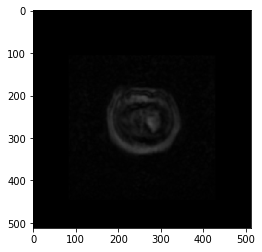

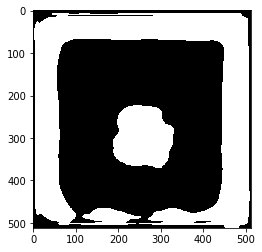

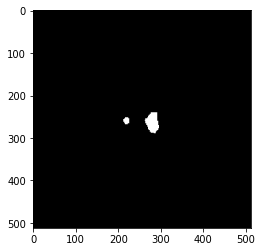


 epoch: 361 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32210395]

 - testing.. 


 epoch: 362 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32273531]

 - testing.. 


 epoch: 363 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32096109]

 - testing.. 


 epoch: 364 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32174742]

 - testing.. 


 epoch: 365 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32149005]

 - testing.. 


 epoch: 366 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32133958]

 - testing.. 


 epoch: 367 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32182372]

 - testing.. 


 epoch: 368 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32142666]

 - testing.. 


 epoch: 369 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32078609]

 - testing.. 


 epoch: 370 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32080731]

 - testing.. 

370 [ 0.43246442]


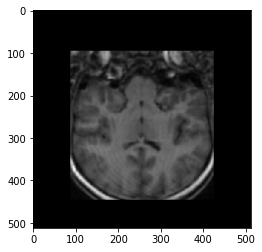

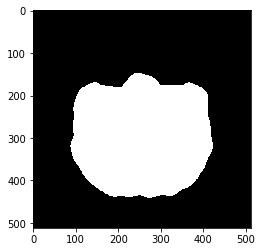

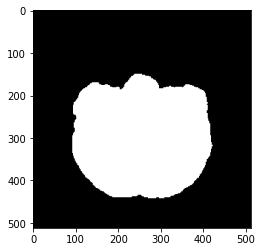


 epoch: 371 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32254225]

 - testing.. 


 epoch: 372 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32052091]

 - testing.. 


 epoch: 373 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32152629]

 - testing.. 


 epoch: 374 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32023105]

 - testing.. 


 epoch: 375 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32119533]

 - testing.. 


 epoch: 376 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3227466]

 - testing.. 


 epoch: 377 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32066917]

 - testing.. 


 epoch: 378 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32216555]

 - testing.. 


 epoch: 379 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32124192]

 - testing.. 


 epoch: 380 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32182768]

 - testing.. 

380 [ 0.38742611]


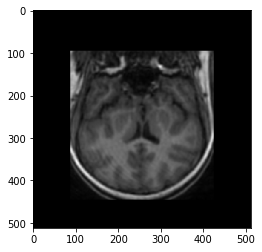

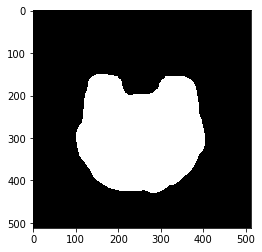

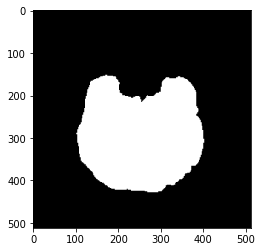


 epoch: 381 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32219386]

 - testing.. 


 epoch: 382 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32103488]

 - testing.. 


 epoch: 383 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32226124]

 - testing.. 


 epoch: 384 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32102558]

 - testing.. 


 epoch: 385 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32219246]

 - testing.. 


 epoch: 386 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32189444]

 - testing.. 


 epoch: 387 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32070005]

 - testing.. 


 epoch: 388 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32083726]

 - testing.. 


 epoch: 389 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3213124]

 - testing.. 


 epoch: 390 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32393536]

 - testing.. 

390 [ 0.38535979]


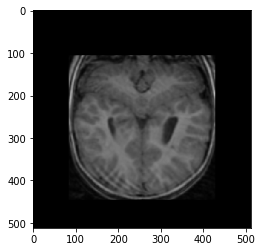

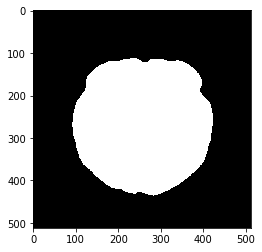

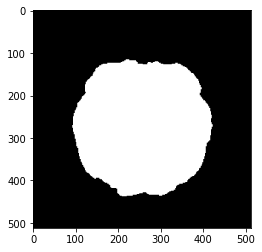


 epoch: 391 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32200387]

 - testing.. 


 epoch: 392 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32288501]

 - testing.. 


 epoch: 393 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32028598]

 - testing.. 


 epoch: 394 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32116255]

 - testing.. 


 epoch: 395 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32062286]

 - testing.. 


 epoch: 396 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32056251]

 - testing.. 


 epoch: 397 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32038742]

 - testing.. 


 epoch: 398 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.320575]

 - testing.. 


 epoch: 399 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32120919]

 - testing.. 


 epoch: 400 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32095024]

 - testing.. 

400 [ 0.32620955]


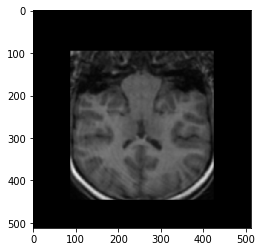

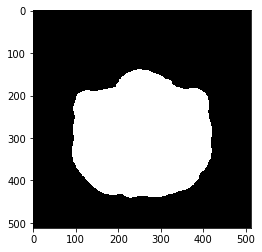

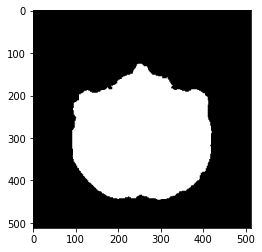


 epoch: 401 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32100365]

 - testing.. 


 epoch: 402 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32103997]

 - testing.. 


 epoch: 403 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32031867]

 - testing.. 


 epoch: 404 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32047555]

 - testing.. 


 epoch: 405 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32102799]

 - testing.. 


 epoch: 406 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32042071]

 - testing.. 


 epoch: 407 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32177654]

 - testing.. 


 epoch: 408 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32162482]

 - testing.. 


 epoch: 409 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32052398]

 - testing.. 


 epoch: 410 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32130507]

 - testing.. 

410 [ 0.326664]


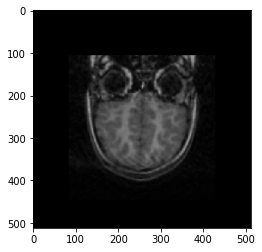

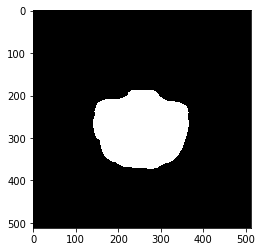

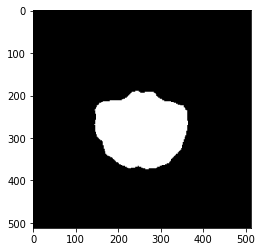


 epoch: 411 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32153073]

 - testing.. 


 epoch: 412 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32106075]

 - testing.. 


 epoch: 413 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32203892]

 - testing.. 


 epoch: 414 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32211]

 - testing.. 


 epoch: 415 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32114255]

 - testing.. 


 epoch: 416 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32137689]

 - testing.. 


 epoch: 417 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32117268]

 - testing.. 


 epoch: 418 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32147589]

 - testing.. 


 epoch: 419 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32267469]

 - testing.. 


 epoch: 420 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32102433]

 - testing.. 

420 [ 0.40205193]


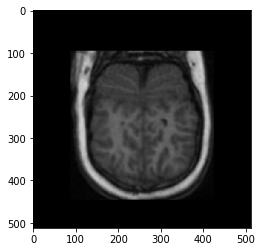

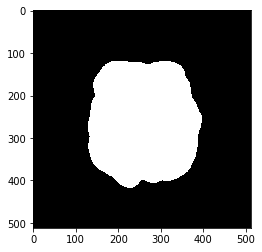

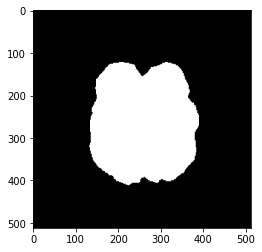


 epoch: 421 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32153791]

 - testing.. 


 epoch: 422 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3218734]

 - testing.. 


 epoch: 423 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32078546]

 - testing.. 


 epoch: 424 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32140797]

 - testing.. 


 epoch: 425 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32124344]

 - testing.. 


 epoch: 426 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32167414]

 - testing.. 


 epoch: 427 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32141808]

 - testing.. 


 epoch: 428 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32155699]

 - testing.. 


 epoch: 429 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32120886]

 - testing.. 


 epoch: 430 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32135871]

 - testing.. 

430 [ 0.41880047]


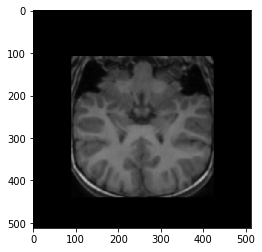

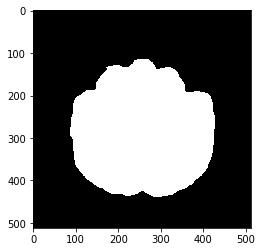

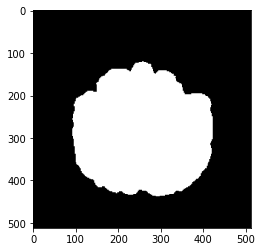


 epoch: 431 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32028636]

 - testing.. 


 epoch: 432 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32186177]

 - testing.. 


 epoch: 433 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32107061]

 - testing.. 


 epoch: 434 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32127368]

 - testing.. 


 epoch: 435 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32106796]

 - testing.. 


 epoch: 436 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32074094]

 - testing.. 


 epoch: 437 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3214362]

 - testing.. 


 epoch: 438 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32098031]

 - testing.. 


 epoch: 439 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32170624]

 - testing.. 


 epoch: 440 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32272148]

 - testing.. 

440 [ 0.51819772]


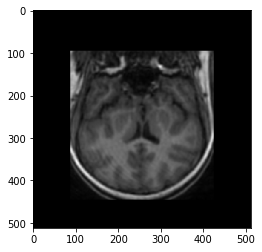

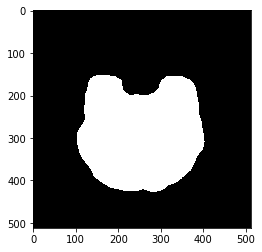

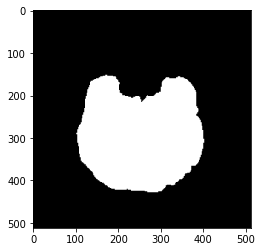


 epoch: 441 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32052189]

 - testing.. 


 epoch: 442 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32070208]

 - testing.. 


 epoch: 443 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3206459]

 - testing.. 


 epoch: 444 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32122177]

 - testing.. 


 epoch: 445 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32039836]

 - testing.. 


 epoch: 446 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32039303]

 - testing.. 


 epoch: 447 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32067198]

 - testing.. 


 epoch: 448 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32132757]

 - testing.. 


 epoch: 449 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32069096]

 - testing.. 


 epoch: 450 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32118461]

 - testing.. 

450 [ 0.50151432]


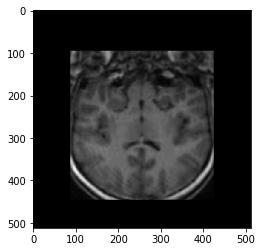

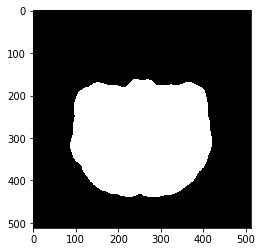

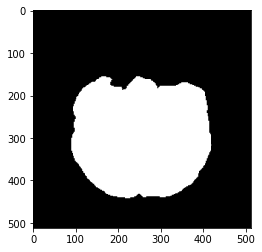


 epoch: 451 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32251599]

 - testing.. 


 epoch: 452 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3226873]

 - testing.. 


 epoch: 453 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32121125]

 - testing.. 


 epoch: 454 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32030597]

 - testing.. 


 epoch: 455 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3210462]

 - testing.. 


 epoch: 456 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3208327]

 - testing.. 


 epoch: 457 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32133922]

 - testing.. 


 epoch: 458 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32037553]

 - testing.. 


 epoch: 459 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3227219]

 - testing.. 


 epoch: 460 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32090038]

 - testing.. 

460 [ 0.32611361]


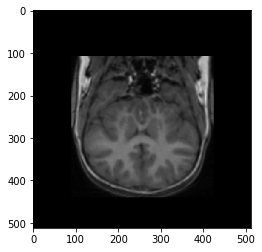

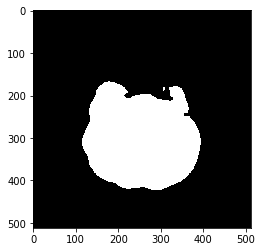

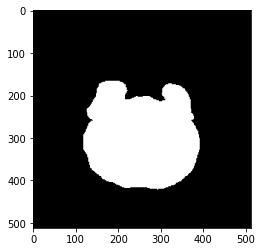


 epoch: 461 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32061499]

 - testing.. 


 epoch: 462 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32160756]

 - testing.. 


 epoch: 463 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3203038]

 - testing.. 


 epoch: 464 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32188436]

 - testing.. 


 epoch: 465 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32109651]

 - testing.. 


 epoch: 466 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32035691]

 - testing.. 


 epoch: 467 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3216624]

 - testing.. 


 epoch: 468 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32182804]

 - testing.. 


 epoch: 469 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32210052]

 - testing.. 


 epoch: 470 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32058841]

 - testing.. 

470 [ 0.42644894]


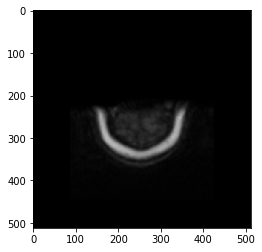

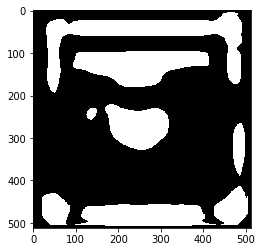

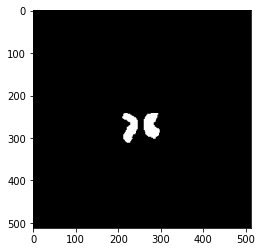


 epoch: 471 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3217971]

 - testing.. 


 epoch: 472 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32129416]

 - testing.. 


 epoch: 473 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32107323]

 - testing.. 


 epoch: 474 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32048184]

 - testing.. 


 epoch: 475 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3219074]

 - testing.. 


 epoch: 476 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32138753]

 - testing.. 


 epoch: 477 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32105064]

 - testing.. 


 epoch: 478 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32113957]

 - testing.. 


 epoch: 479 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3197287]

 - testing.. 


 epoch: 480 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32094499]

 - testing.. 

480 [ 0.32829517]


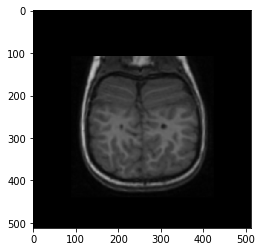

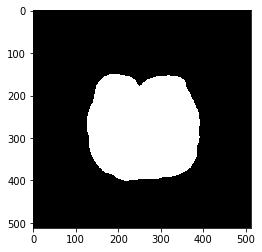

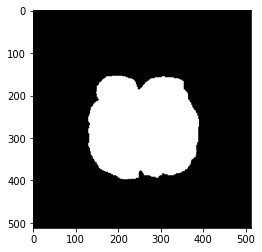


 epoch: 481 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32109171]

 - testing.. 


 epoch: 482 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32114923]

 - testing.. 


 epoch: 483 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3207449]

 - testing.. 


 epoch: 484 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32109499]

 - testing.. 


 epoch: 485 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32150638]

 - testing.. 


 epoch: 486 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32139114]

 - testing.. 


 epoch: 487 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32102138]

 - testing.. 


 epoch: 488 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32253298]

 - testing.. 


 epoch: 489 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32150295]

 - testing.. 


 epoch: 490 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32221675]

 - testing.. 

490 [ 0.36305466]


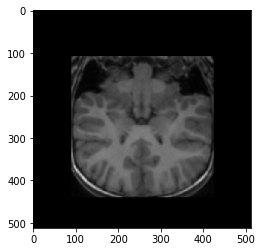

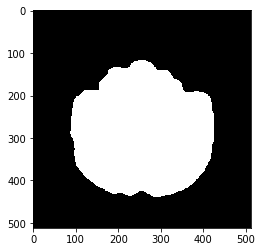

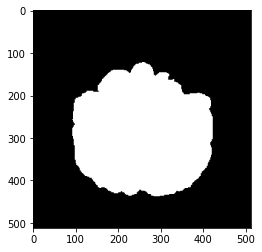


 epoch: 491 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3214595]

 - testing.. 


 epoch: 492 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32183513]

 - testing.. 


 epoch: 493 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32135627]

 - testing.. 


 epoch: 494 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32116288]

 - testing.. 


 epoch: 495 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32161134]

 - testing.. 


 epoch: 496 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32210881]

 - testing.. 


 epoch: 497 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32049912]

 - testing.. 


 epoch: 498 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32103851]

 - testing.. 


 epoch: 499 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32249925]

 - testing.. 


 epoch: 500 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32106003]

 - testing.. 

500 [ 0.3311227]


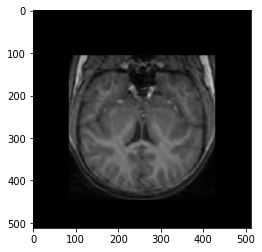

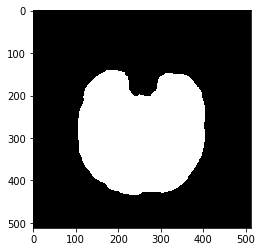

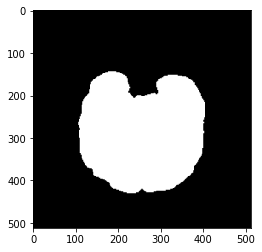


 epoch: 501 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32008004]

 - testing.. 


 epoch: 502 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32037395]

 - testing.. 


 epoch: 503 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32024401]

 - testing.. 


 epoch: 504 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32061762]

 - testing.. 


 epoch: 505 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32095513]

 - testing.. 


 epoch: 506 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32145327]

 - testing.. 


 epoch: 507 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32097766]

 - testing.. 


 epoch: 508 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.3205184]

 - testing.. 


 epoch: 509 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32059121]

 - testing.. 


 epoch: 510 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32207739]

 - testing.. 

510 [ 0.47000253]


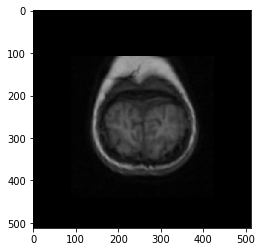

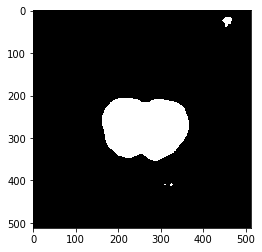

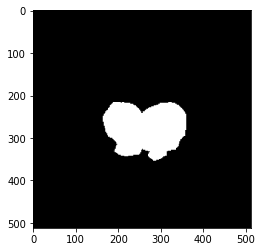


 epoch: 511 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32271737]

 - testing.. 


 epoch: 512 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32117966]

 - testing.. 


 epoch: 513 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32165062]

 - testing.. 


 epoch: 514 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32037458]

 - testing.. 


 epoch: 515 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32097104]

 - testing.. 


 epoch: 516 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32098627]

 - testing.. 


 epoch: 517 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32089645]

 - testing.. 


 epoch: 518 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32237288]

 - testing.. 


 epoch: 519 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32153586]

 - testing.. 


 epoch: 520 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32082716]

 - testing.. 

520 [ 0.40449053]


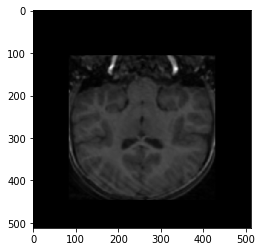

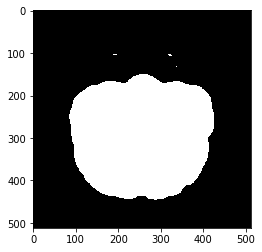

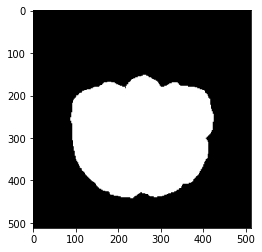


 epoch: 521 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32055369]

 - testing.. 


 epoch: 522 

 - training.. 



/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[ 0.32054797]

 - testing.. 



Process Process-2094:
Process Process-2093:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 46, in _worker_loop
    data_queue.put((idx, samples))
  File "/home/ubuntu/anaconda3/

KeyboardInterrupt: 

In [11]:
for i in range(epoch):
    rand_rotate,rand_ud,rand_lr,rand_gaussian,rand_crop,crop_start = randomize()    
    print("\n epoch: {} \n".format(i))
    print(" - training.. \n")
    
    for image,_ in train_batch:
        
        rand_rotate,rand_ud,rand_lr,rand_gaussian,rand_crop,crop_start = randomize()    
        
        image, label = torch.chunk(image,chunks=2, dim=3)
        label = label[:,0,:,:]
        
        optimizer.zero_grad()
        
        img_var = Variable(image).cuda()
        label_var = Variable(label.type_as(torch.LongTensor())).cuda()  

        output = model(img_var)
        
        loss = loss_function_crossentropy(output,label_var)
        loss.backward()
        
        optimizer.step()
        
    print(loss.cpu().data.numpy())
    print("\n - testing.. \n")
    
    for image,_ in test_batch:
        image, label = torch.chunk(image,chunks=2, dim=3)

        label = label[:,0,:,:]
        
        img_var = Variable(image).cuda()
        label_var = Variable(label.type_as(torch.LongTensor())).cuda() 

        output = model(img_var)
        loss = loss_function_crossentropy(output,label_var)
        
    if i%10 ==0:
        print(i,loss.cpu().data.numpy())
        variable_visualizer(img_var,output,label)
        torch.save(model.state_dict(),"./saved_model/last_model_{}.pkl".format(i,loss.cpu().data.numpy()))


## Test on Miccai 2008

In [ ]:

PATH = "./saved_model/crossentropy_minmaxnorm/last_model_900.pkl"

model = nn.DataParallel(UnetGenerator(in_dim = in_dim,out_dim = out_dim, num_filter = num_filter)).cuda()
model.load_state_dict(torch.load(PATH))


In [12]:
infer_dir = "./miccai_before/"
infer_data = dset.ImageFolder(root=infer_dir, transform = transforms.Compose([
                                            transforms.Resize(size=img_size),
                                            transforms.ToTensor(),
                                            #transforms.Lambda(lambda x: minmax_norm(x,infer=True)),
                                            ]))
infer_batch = data.DataLoader(infer_data, batch_size=test_batch_size,
                            shuffle=False, num_workers=2)

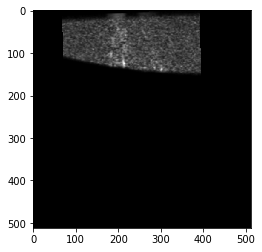

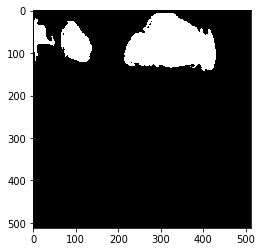

label not shown


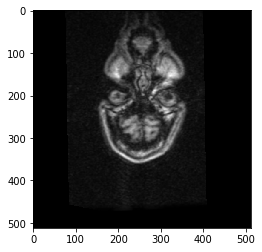

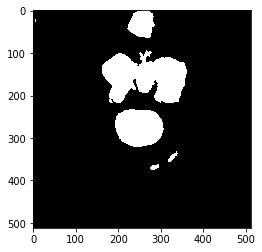

label not shown


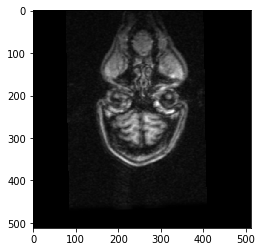

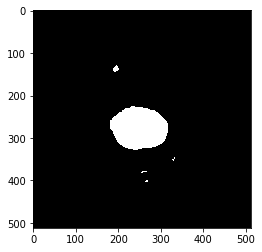

label not shown


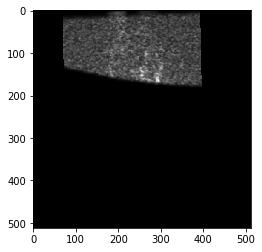

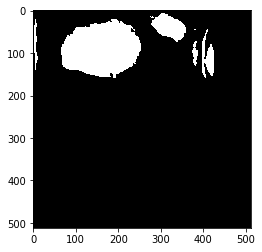

label not shown


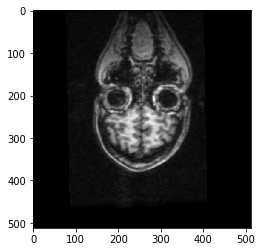

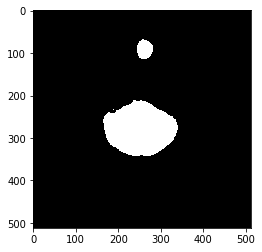

label not shown


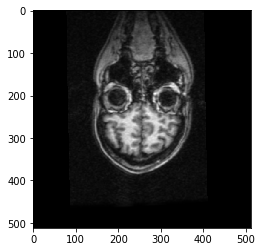

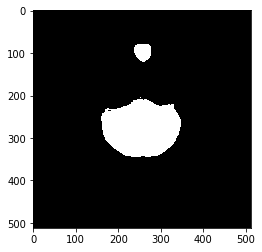

label not shown


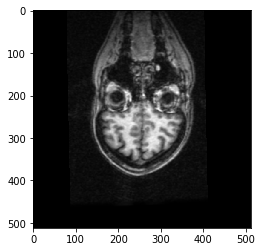

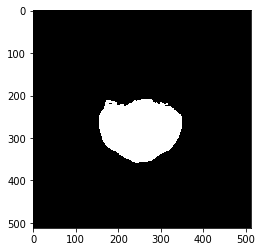

label not shown


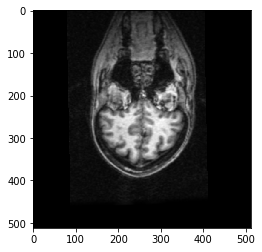

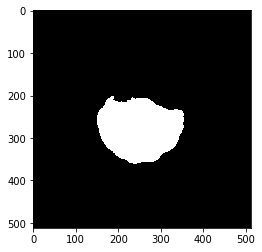

label not shown


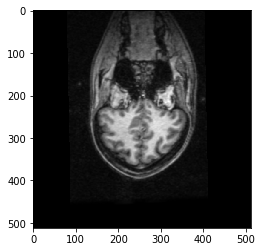

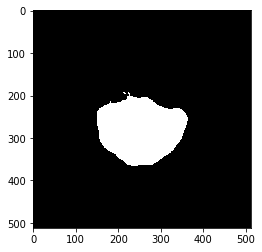

label not shown


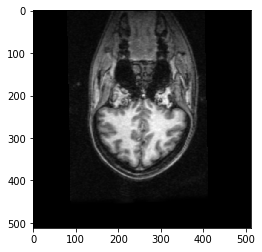

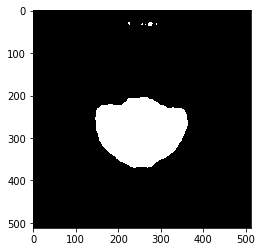

label not shown


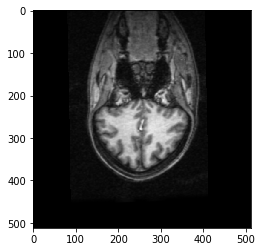

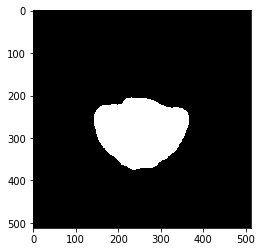

label not shown


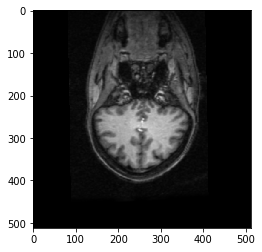

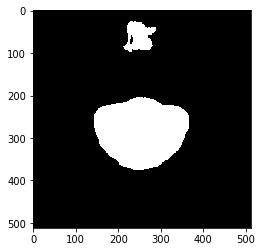

label not shown


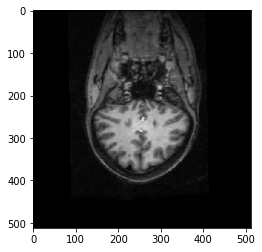

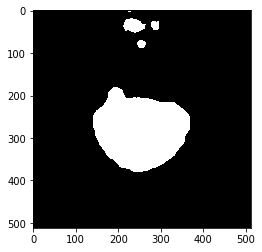

label not shown


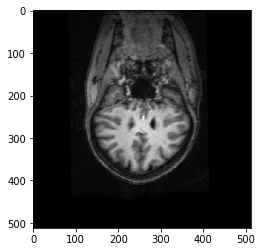

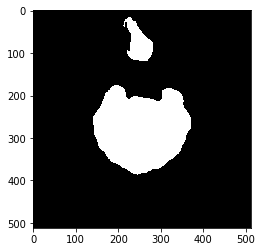

label not shown


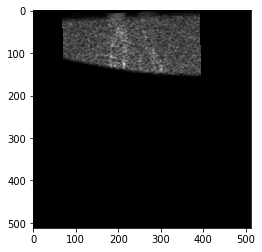

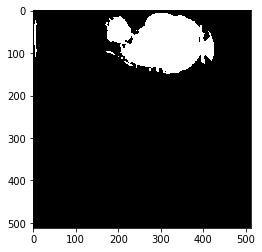

label not shown


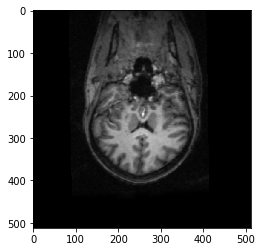

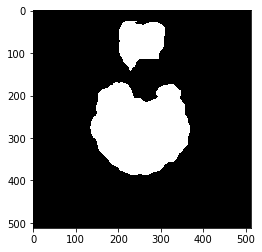

label not shown


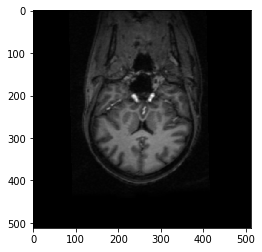

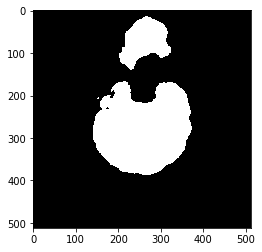

label not shown


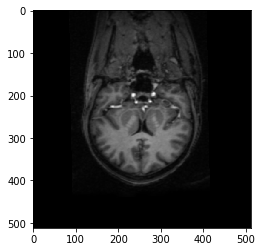

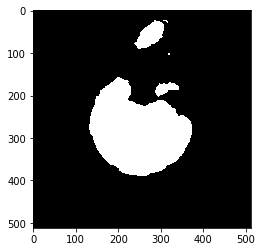

label not shown


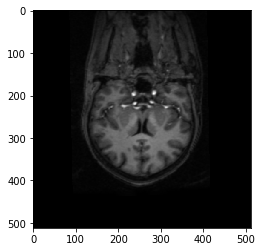

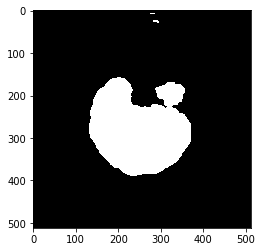

label not shown


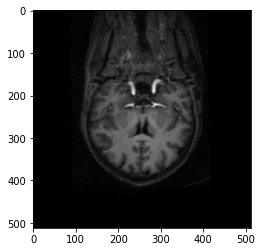

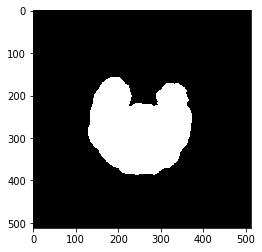

label not shown


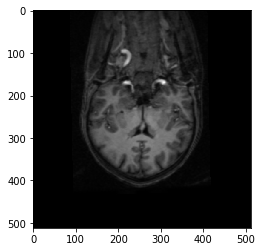

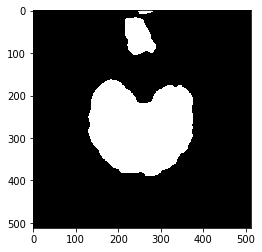

label not shown


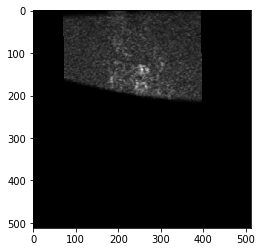

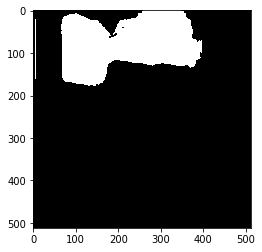

label not shown


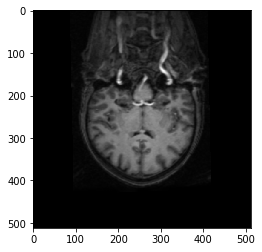

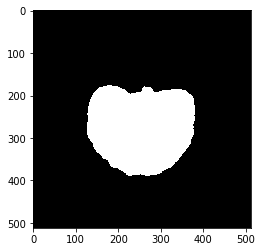

label not shown


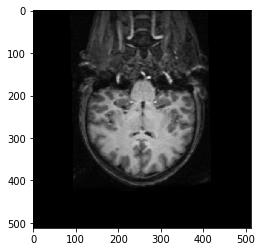

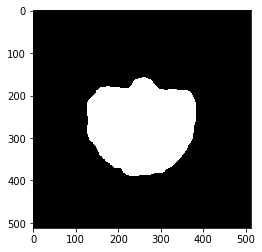

label not shown


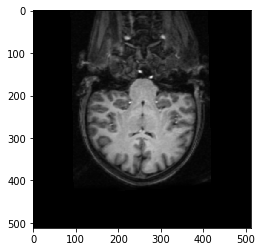

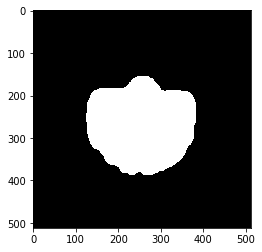

label not shown


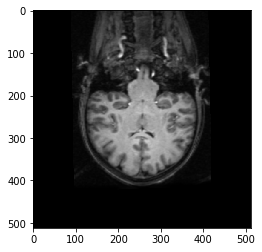

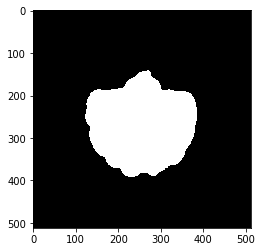

label not shown


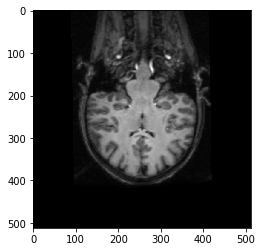

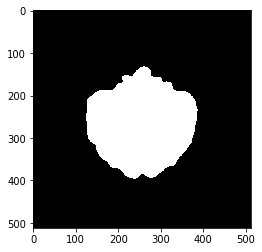

label not shown


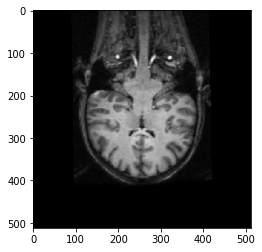

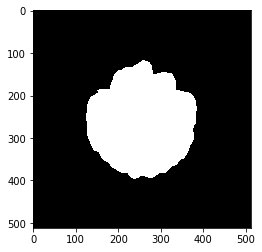

label not shown


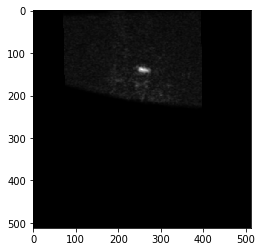

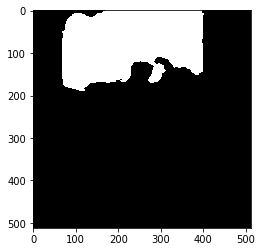

label not shown


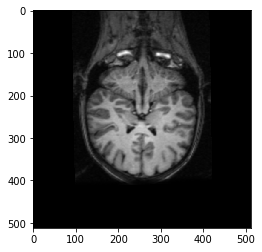

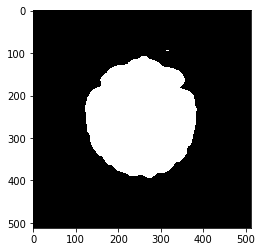

label not shown


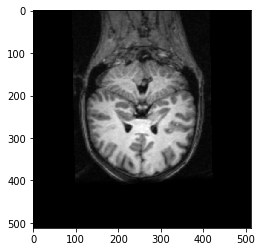

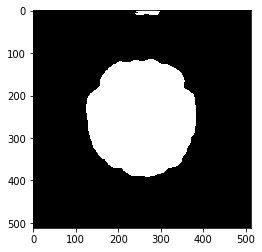

label not shown


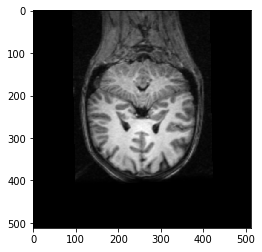

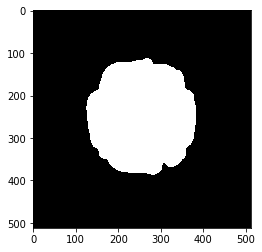

label not shown


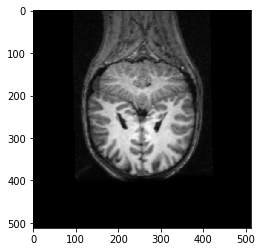

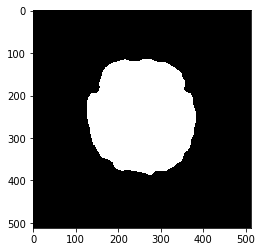

label not shown


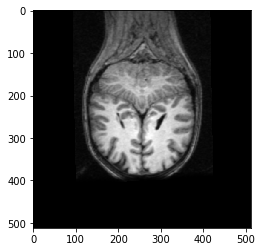

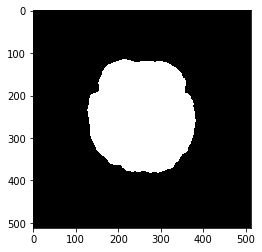

label not shown


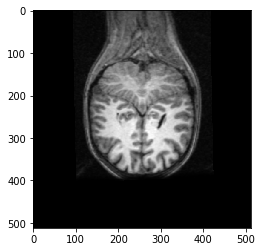

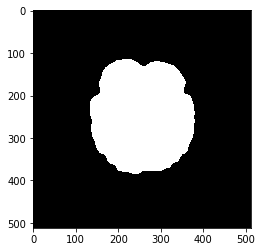

label not shown


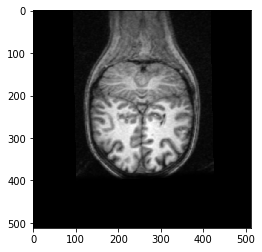

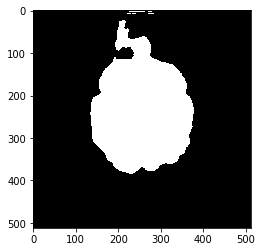

label not shown


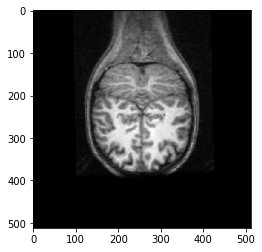

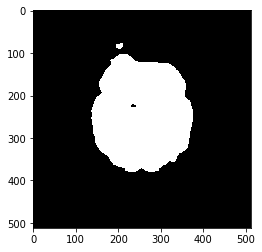

label not shown


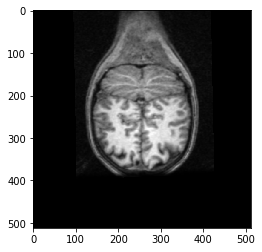

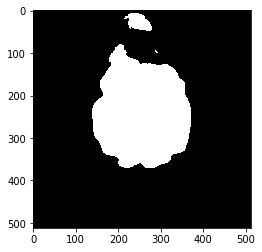

label not shown


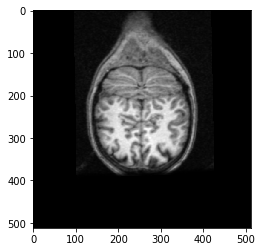

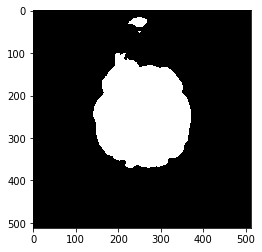

label not shown


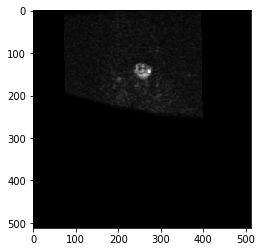

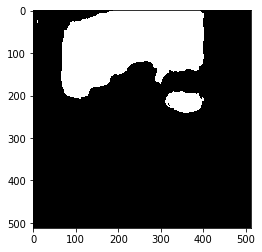

label not shown


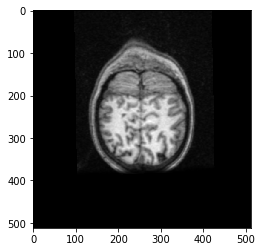

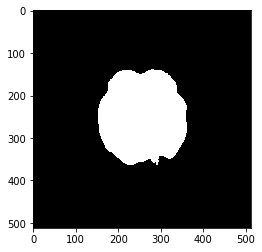

label not shown


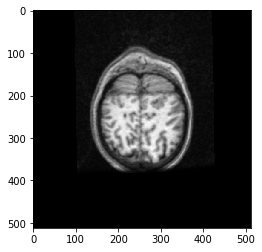

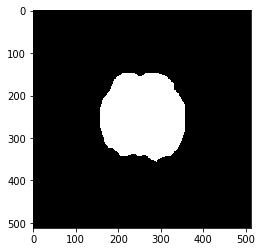

label not shown


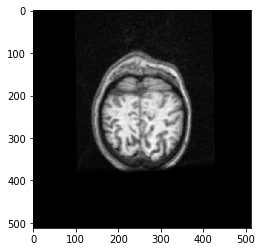

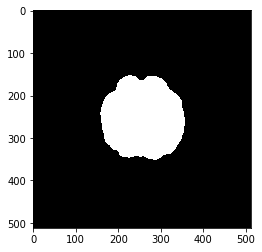

label not shown


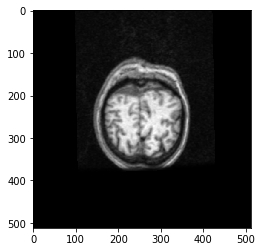

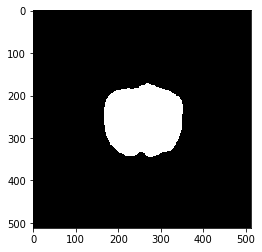

label not shown


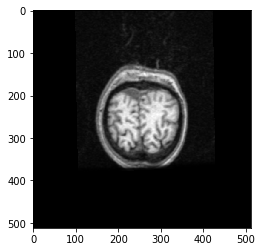

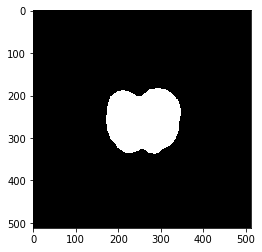

label not shown


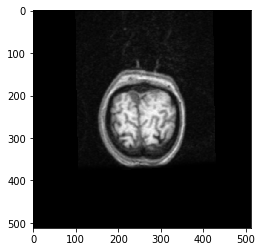

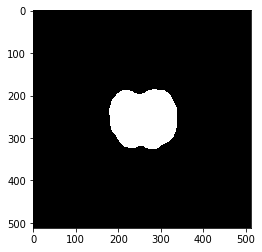

label not shown


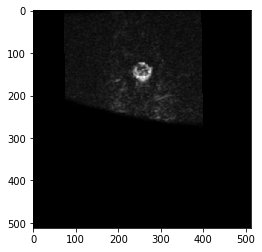

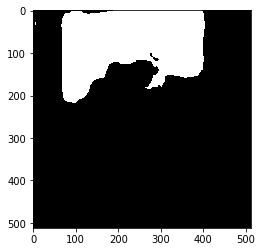

label not shown


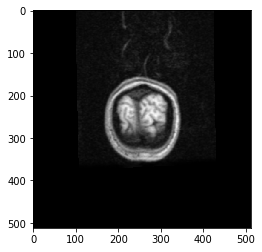

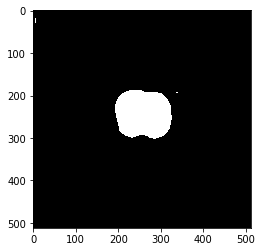

label not shown


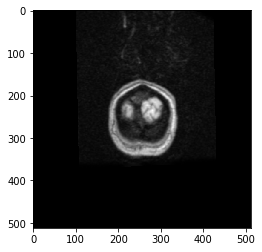

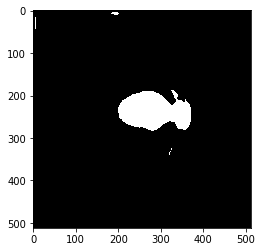

label not shown


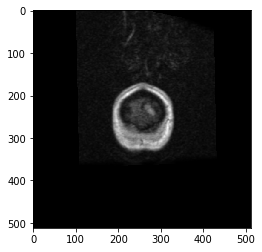

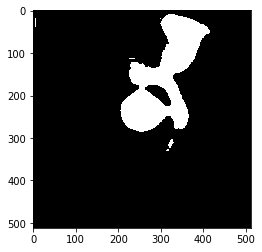

label not shown


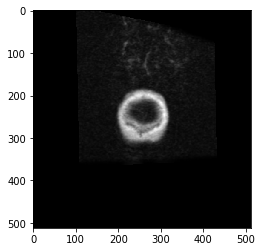

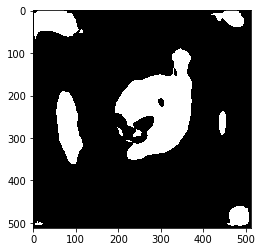

label not shown


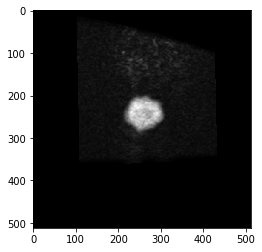

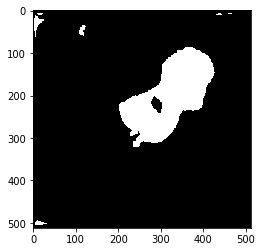

label not shown


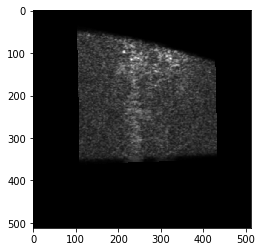

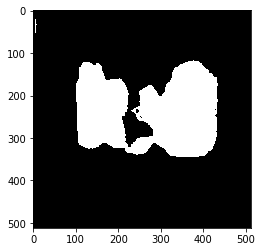

label not shown


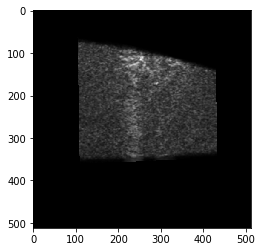

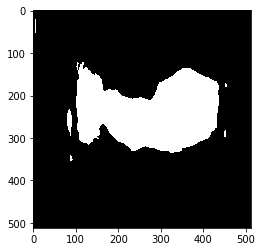

label not shown


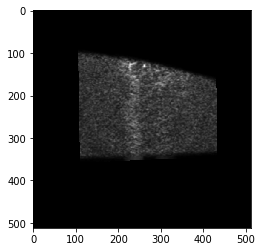

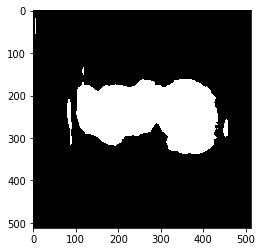

label not shown


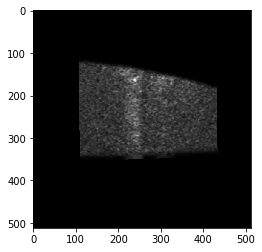

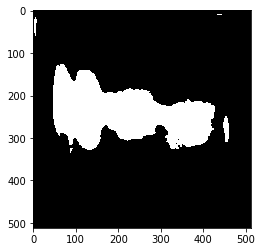

label not shown


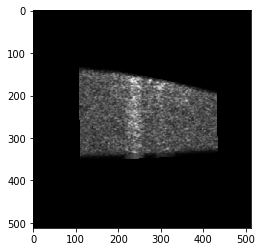

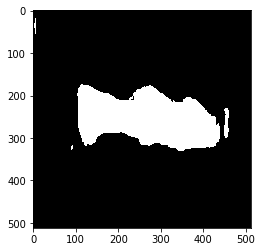

label not shown


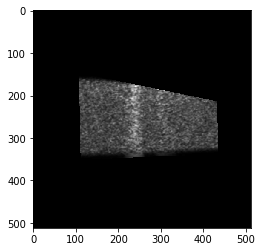

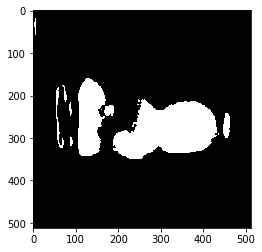

label not shown


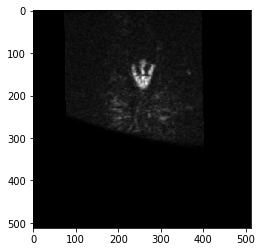

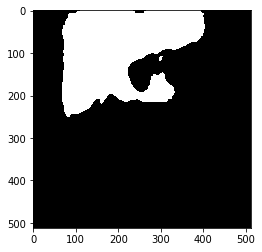

label not shown


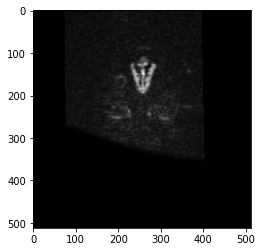

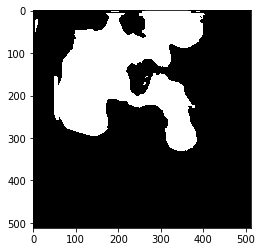

label not shown


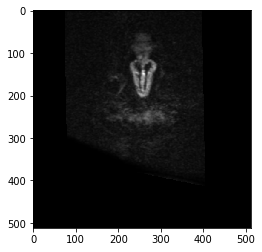

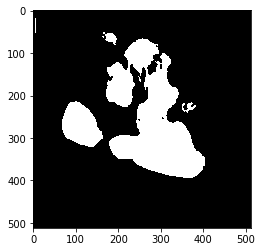

label not shown


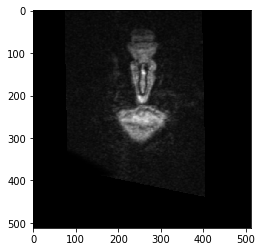

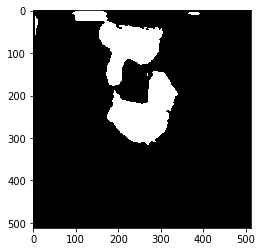

label not shown


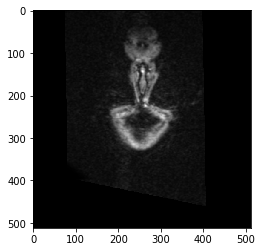

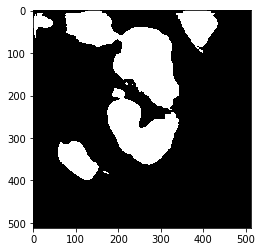

label not shown


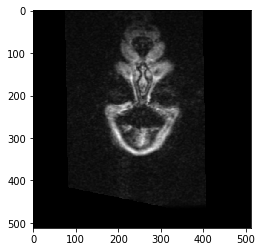

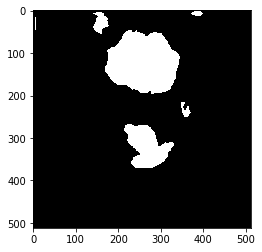

label not shown


In [13]:
for image,label in infer_batch:
    
    img_var = Variable(image).cuda()
    
    output = model(img_var)    
    variable_visualizer(img_var,output,label)